# 📰 MIND News Recommendation System

## Architecture Overview:
1. **News Encoder:** BERT/RoBERTa + Attention Pooling (Title → Vector)
2. **User Encoder:** Attention Pooling over history (History → User Vector)
3. **Prediction:** Dot product similarity + Softmax
4. **Training:** Negative Sampling with Cross-Entropy Loss

## Pipeline:
```
User History → News Encoder → User Encoder → User Vector
                                                  ↓
Candidate News → News Encoder → Candidate Vectors → Dot Product → Click Probability
```


## 📦 Import Libraries


In [1]:
%pip install numpy==1.26.4 pandas==2.3.3 matplotlib seaborn tqdm torch transformers scikit-learn

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

# Set style for better plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ All libraries imported successfully!")


Note: you may need to restart the kernel to use updated packages.


/Users/lenhathoang/miniconda3/envs/recsys/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully!


## ⚙️ Configuration


In [2]:
config = {
    # Data Paths
    'NEWS_TRAIN_PATH': 'MIND/MINDsmall/MINDsmall_train/news.tsv',
    'BEHAVIORS_TRAIN_PATH': 'MIND/MINDsmall/MINDsmall_train/behaviors.tsv',
    'NEWS_VAL_PATH': 'MIND/MINDsmall/MINDsmall_dev/news.tsv',
    'BEHAVIORS_VAL_PATH': 'MIND/MINDsmall/MINDsmall_dev/behaviors.tsv',
    
    # Model Settings
    'MODEL_NAME': 'roberta-base',  # Options: 'bert-base-uncased', 'roberta-base', 'distilbert-base-uncased'
    'EMBEDDING_DIM': 768,
    'ATTENTION_QUERY_DIM': 200,
    
    # Training Settings
    'MAX_TITLE_LEN': 25,      # Max words in news title
    'MAX_HISTORY_LEN': 20,    # Max clicked news to consider for user
    'NEG_SAMPLES': 4,         # Number of negative samples per positive click
    'BATCH_SIZE': 32,
    'EPOCHS': 3,
    'LR': 4e-5,
    
    # Hardware
    'DEVICE': torch.device('mps'),
    
    # Debug / Testing
    'LOAD_CHECKPOINT': True,
    'DEBUG_SUBSET_SIZE': 500,  # Set to 0 to use full dataset
}

print("="*60)
print("🔧 CONFIGURATION")
print("="*60)
for key, value in config.items():
    print(f"  {key:20s}: {value}")
print("="*60)


🔧 CONFIGURATION
  NEWS_TRAIN_PATH     : MIND/MINDsmall/MINDsmall_train/news.tsv
  BEHAVIORS_TRAIN_PATH: MIND/MINDsmall/MINDsmall_train/behaviors.tsv
  NEWS_VAL_PATH       : MIND/MINDsmall/MINDsmall_dev/news.tsv
  BEHAVIORS_VAL_PATH  : MIND/MINDsmall/MINDsmall_dev/behaviors.tsv
  MODEL_NAME          : roberta-base
  EMBEDDING_DIM       : 768
  ATTENTION_QUERY_DIM : 200
  MAX_TITLE_LEN       : 25
  MAX_HISTORY_LEN     : 20
  NEG_SAMPLES         : 4
  BATCH_SIZE          : 32
  EPOCHS              : 3
  LR                  : 4e-05
  DEVICE              : mps
  LOAD_CHECKPOINT     : True
  DEBUG_SUBSET_SIZE   : 500


## 📰 Load and Explore News Data


In [3]:
print("📰 Loading News Articles...")

# Load training news
news_train_df = pd.read_csv(config['NEWS_TRAIN_PATH'], sep='\t', header=None, usecols=[0, 3])
news_train_df.columns = ['news_id', 'title']
print(f"  Training news: {len(news_train_df):,} articles")

# Load validation news
news_val_df = pd.read_csv(config['NEWS_VAL_PATH'], sep='\t', header=None, usecols=[0, 3])
news_val_df.columns = ['news_id', 'title']
print(f"  Validation news: {len(news_val_df):,} articles")

# Combine and deduplicate (some news may appear in both)
news_df = pd.concat([news_train_df, news_val_df]).drop_duplicates(subset=['news_id'])
print(f"✅ Loaded {len(news_df):,} unique news articles (combined)")

print(f"\n📋 Sample News Articles:")
news_df.head(10)

📰 Loading News Articles...
  Training news: 51,282 articles
  Validation news: 42,416 articles
✅ Loaded 65,238 unique news articles (combined)

📋 Sample News Articles:


,news_id,title
0,N55528,"The Brands Queen Elizabeth, Prince Charles, an..."
1,N19639,50 Worst Habits For Belly Fat
2,N61837,The Cost of Trump's Aid Freeze in the Trenches...
3,N53526,I Was An NBA Wife. Here's How It Affected My M...
4,N38324,"How to Get Rid of Skin Tags, According to a De..."
5,N2073,Should NFL be able to fine players for critici...
6,N49186,It's been Orlando's hottest October ever so fa...
7,N59295,Chile: Three die in supermarket fire amid prot...
8,N24510,Best PS5 games: top PlayStation 5 titles to lo...
9,N39237,"How to report weather-related closings, delays"


### 📊 Visualize News Characteristics


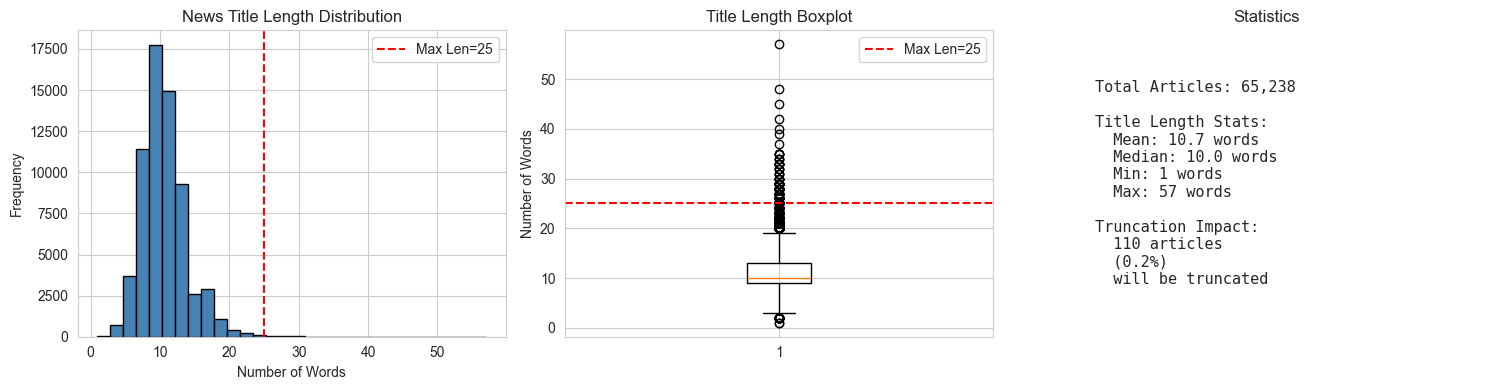

📊 Average title length: 10.7 words
📊 110 articles will be truncated


In [4]:
# Analyze title characteristics
news_df['title_length'] = news_df['title'].str.split().str.len()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Title length distribution
axes[0].hist(news_df['title_length'], bins=30, edgecolor='black', color='steelblue')
axes[0].axvline(config['MAX_TITLE_LEN'], color='red', linestyle='--', label=f'Max Len={config["MAX_TITLE_LEN"]}')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('News Title Length Distribution')
axes[0].legend()

# Boxplot
axes[1].boxplot(news_df['title_length'], vert=True)
axes[1].axhline(config['MAX_TITLE_LEN'], color='red', linestyle='--', label=f'Max Len={config["MAX_TITLE_LEN"]}')
axes[1].set_ylabel('Number of Words')
axes[1].set_title('Title Length Boxplot')
axes[1].legend()

# Statistics
stats_text = f"""
Total Articles: {len(news_df):,}

Title Length Stats:
  Mean: {news_df['title_length'].mean():.1f} words
  Median: {news_df['title_length'].median():.1f} words
  Min: {news_df['title_length'].min()} words
  Max: {news_df['title_length'].max()} words
  
Truncation Impact:
  {(news_df['title_length'] > config['MAX_TITLE_LEN']).sum():,} articles 
  ({(news_df['title_length'] > config['MAX_TITLE_LEN']).mean()*100:.1f}%)
  will be truncated
"""
axes[2].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center', family='monospace')
axes[2].axis('off')
axes[2].set_title('Statistics')

plt.tight_layout()
plt.show()

print(f"📊 Average title length: {news_df['title_length'].mean():.1f} words")
print(f"📊 {(news_df['title_length'] > config['MAX_TITLE_LEN']).sum():,} articles will be truncated")


## 🔤 Tokenize News Articles


In [5]:
print(f"🔤 Initializing tokenizer: {config['MODEL_NAME']}...")
tokenizer = AutoTokenizer.from_pretrained(config['MODEL_NAME'])

def tokenize_news(text):
    return tokenizer(
        text, 
        max_length=config['MAX_TITLE_LEN'], 
        padding='max_length', 
        truncation=True, 
        return_tensors='pt'
    )

print("🔄 Tokenizing all news articles...")
news_features = {}
for idx, row in tqdm(news_df.iterrows(), total=len(news_df), desc="Tokenizing"):
    news_features[row['news_id']] = tokenize_news(row['title'])

# Add padding token for empty history slots
news_features['<PAD>'] = tokenize_news("")

print(f"✅ Tokenized {len(news_features):,} news articles (including <PAD>)")


🔤 Initializing tokenizer: roberta-base...
🔄 Tokenizing all news articles...


Tokenizing: 100%|██████████| 65238/65238 [00:04<00:00, 13378.68it/s]

✅ Tokenized 65,239 news articles (including <PAD>)


### 🔍 Inspect Tokenization Example


In [6]:
# Show tokenization example
example_idx = 20
example_news_id = news_df.iloc[example_idx]['news_id']
example_title = news_df.iloc[example_idx]['title']
example_tokens = news_features[example_news_id]

print("="*80)
print("📝 TOKENIZATION EXAMPLE")
print("="*80)
print(f"News ID: {example_news_id}")
print(f"Original Title: {example_title}")
print(f"\nTitle Length: {len(example_title.split())} words")
print(f"Token IDs Shape: {example_tokens['input_ids'].shape}")
print(f"\nToken IDs (first 15): {example_tokens['input_ids'][0][:15].tolist()}")
print(f"\nDecoded (with special tokens): {tokenizer.decode(example_tokens['input_ids'][0])}")
print(f"\nDecoded (clean): {tokenizer.decode(example_tokens['input_ids'][0], skip_special_tokens=True)}")
print("="*80)


📝 TOKENIZATION EXAMPLE
News ID: N9786
Original Title: Elijah Cummings to lie in state at US Capitol Thursday

Title Length: 10 words
Token IDs Shape: torch.Size([1, 25])

Token IDs (first 15): [0, 9682, 44303, 20342, 7, 6105, 11, 194, 23, 382, 6107, 296, 2, 1, 1]

Decoded (with special tokens): <s>Elijah Cummings to lie in state at US Capitol Thursday</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

Decoded (clean): Elijah Cummings to lie in state at US Capitol Thursday


## 👤 Load and Analyze User Behaviors


In [7]:
print("👤 Loading user behaviors...")
behaviors_df = pd.read_csv(config['BEHAVIORS_TRAIN_PATH'], sep='\t', header=None)
behaviors_df.columns = ['impression_id', 'user_id', 'time', 'history', 'impressions']

# Apply debug subset if configured
if config['DEBUG_SUBSET_SIZE'] > 0:
    behaviors_df = behaviors_df.head(config['DEBUG_SUBSET_SIZE'])
    print(f"🔍 DEBUG MODE: Using only {len(behaviors_df):,} behaviors")
else:
    print(f"✅ Loaded {len(behaviors_df):,} user behaviors")

print(f"\n📋 Sample Behaviors:")
behaviors_df.head()


👤 Loading user behaviors...
🔍 DEBUG MODE: Using only 500 behaviors

📋 Sample Behaviors:


,impression_id,user_id,time,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,11/11/2019 5:28:05 AM,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,11/12/2019 4:11:21 PM,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


### 📊 Analyze User Behavior Patterns


📊 Analyzing behavior patterns...


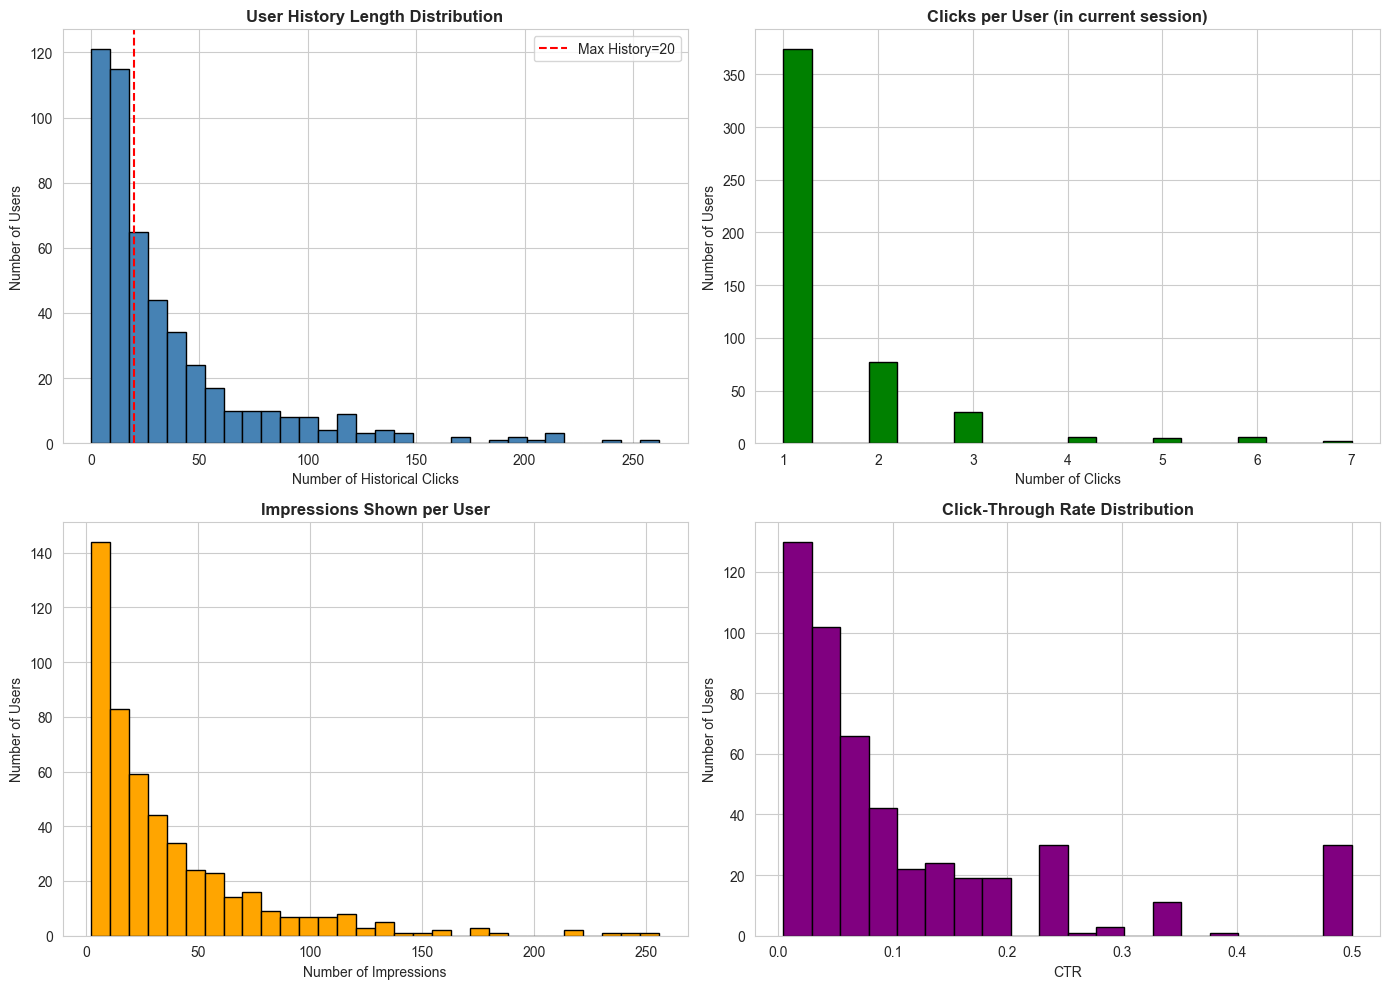


📈 Behavior Statistics:
  Average history length: 34.1 articles
  Average clicks per user: 1.4
  Average impressions per user: 35.7
  Average CTR: 11.08%
  Users with no history: 7 (1.4%)


In [8]:
# Parse behavior patterns
print("📊 Analyzing behavior patterns...")

behaviors_df['history_count'] = behaviors_df['history'].apply(
    lambda x: len(str(x).split()) if str(x) != 'nan' else 0
)

def parse_impressions(imp_str):
    clicks = 0
    impressions = 0
    for imp in str(imp_str).split():
        nid, label = imp.split('-')
        impressions += 1
        if label == '1':
            clicks += 1
    return clicks, impressions

behaviors_df['clicks'], behaviors_df['total_impressions'] = zip(
    *behaviors_df['impressions'].apply(parse_impressions)
)
behaviors_df['ctr'] = behaviors_df['clicks'] / behaviors_df['total_impressions']

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# History length distribution
axes[0, 0].hist(behaviors_df['history_count'], bins=30, edgecolor='black', color='steelblue')
axes[0, 0].axvline(config['MAX_HISTORY_LEN'], color='red', linestyle='--', 
                   label=f'Max History={config["MAX_HISTORY_LEN"]}')
axes[0, 0].set_title('User History Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Historical Clicks')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].legend()

# Clicks per user
axes[0, 1].hist(behaviors_df['clicks'], bins=20, edgecolor='black', color='green')
axes[0, 1].set_title('Clicks per User (in current session)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Clicks')
axes[0, 1].set_ylabel('Number of Users')

# Impressions per user
axes[1, 0].hist(behaviors_df['total_impressions'], bins=30, edgecolor='black', color='orange')
axes[1, 0].set_title('Impressions Shown per User', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Impressions')
axes[1, 0].set_ylabel('Number of Users')

# CTR distribution
axes[1, 1].hist(behaviors_df['ctr'], bins=20, edgecolor='black', color='purple')
axes[1, 1].set_title('Click-Through Rate Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('CTR')
axes[1, 1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

print("\n📈 Behavior Statistics:")
print(f"  Average history length: {behaviors_df['history_count'].mean():.1f} articles")
print(f"  Average clicks per user: {behaviors_df['clicks'].mean():.1f}")
print(f"  Average impressions per user: {behaviors_df['total_impressions'].mean():.1f}")
print(f"  Average CTR: {behaviors_df['ctr'].mean():.2%}")
print(f"  Users with no history: {(behaviors_df['history_count'] == 0).sum():,} ({(behaviors_df['history_count'] == 0).mean()*100:.1f}%)")


### 🔍 Explore Sample User Behavior


In [9]:
# Show a detailed example of one user's behavior
sample_behavior = behaviors_df.iloc[10]

print("="*80)
print("👤 SAMPLE USER BEHAVIOR")
print("="*80)
print(f"User ID: {sample_behavior['user_id']}")
print(f"Time: {sample_behavior['time']}")
print(f"\n📚 HISTORY ({sample_behavior['history_count']} articles clicked previously):")

history_ids = str(sample_behavior['history']).split() if str(sample_behavior['history']) != 'nan' else []
for i, nid in enumerate(history_ids[:5], 1):  # Show first 5
    if nid in news_df['news_id'].values:
        title = news_df[news_df['news_id'] == nid]['title'].values[0]
        print(f"  {i}. {title}")
if len(history_ids) > 5:
    print(f"  ... and {len(history_ids) - 5} more")

print(f"\n🎯 IMPRESSIONS SHOWN (Total: {sample_behavior['total_impressions']}):")
impressions = str(sample_behavior['impressions']).split()
for i, imp in enumerate(impressions[:10], 1):  # Show first 10
    nid, label = imp.split('-')
    if nid in news_df['news_id'].values:
        title = news_df[news_df['news_id'] == nid]['title'].values[0]
        status = "✅ CLICKED" if label == '1' else "❌ IGNORED"
        print(f"  {i}. {status}: {title}")
if len(impressions) > 10:
    print(f"  ... and {len(impressions) - 10} more")

print(f"\n📊 User CTR: {sample_behavior['ctr']:.2%} ({sample_behavior['clicks']} clicks / {sample_behavior['total_impressions']} impressions)")
print("="*80)


👤 SAMPLE USER BEHAVIOR
User ID: U89744
Time: 11/14/2019 8:38:04 AM

📚 HISTORY (78 articles clicked previously):
  1. Lamar Jackson makes NFL history with huge day in win over Bengals
  2. Steve Kerr: Steph Curry is 'at his peak physically, mentally'
  3. Celtics, Zion remain sizzling to start preseason
  4. Kate Upton was so fired up after the Astros' big defensive play
  5. NASCAR driver's car got flipped over and then stuck the landing in wild wreck at Talladega
  ... and 73 more

🎯 IMPRESSIONS SHOWN (Total: 241):
  1. ❌ IGNORED: A Trump Tax Break To Help The Poor Went To a Rich GOP Donor's Superyacht Marina
  2. ❌ IGNORED: Family told to take down Christmas display because it's too soon to decorate
  3. ❌ IGNORED: Report: Knicks' brass will stay on if team shows 'progress' this season
  4. ❌ IGNORED: An investor's guide to space, Wall Street's next trillion-dollar industry
  5. ❌ IGNORED: A teen received a response to a message in a bottle he wrote 9 years ago after it traveled over

## 🎯 Create Training Samples


### Splitting the train dataset

In [10]:
# print("🎯 Creating training samples with negative sampling...")
# print(f"   Strategy: 1 positive + {config['NEG_SAMPLES']} negative samples per training example")

# train_samples = []
# val_samples = []

# for idx, row in tqdm(behaviors_df.iterrows(), total=len(behaviors_df), desc="Creating samples"):
#     history_str = str(row['history'])
#     impressions_str = str(row['impressions'])
    
#     # Parse history
#     history = history_str.split() if history_str != 'nan' else []
#     history = history[:config['MAX_HISTORY_LEN']]  # Truncate to max length
    
#     # Parse impressions into positive and negative
#     pos_news = []
#     neg_news = []
    
#     for imp in impressions_str.split():
#         nid, label = imp.split('-')
#         if label == '1':
#             pos_news.append(nid)
#         else:
#             neg_news.append(nid)
    
#     # Create training samples (80%) and validation samples (20%)
#     is_train = random.random() < 0.8
    
#     if is_train:
#         # Training: Create multiple samples with negative sampling
#         for pos in pos_news:
#             if not neg_news:
#                 continue
            
#             # Sample negatives
#             if len(neg_news) < config['NEG_SAMPLES']:
#                 negs = random.choices(neg_news, k=config['NEG_SAMPLES'])
#             else:
#                 negs = random.sample(neg_news, config['NEG_SAMPLES'])
            
#             train_samples.append({
#                 'history': history,
#                 'candidates': [pos] + negs,  # First one is always positive
#                 'label': 0  # Index of positive sample
#             })
#     else:
#         # Validation: Keep all impressions for ranking evaluation
#         if pos_news:
#             val_samples.append({
#                 'history': history,
#                 'candidates': pos_news + neg_news,
#                 'label': [1] * len(pos_news) + [0] * len(neg_news)
#             })

# print(f"\n✅ Created {len(train_samples):,} training samples")
# print(f"✅ Created {len(val_samples):,} validation samples")
# print(f"\n📊 Split: {len(train_samples)/(len(train_samples)+len(val_samples))*100:.1f}% train, {len(val_samples)/(len(train_samples)+len(val_samples))*100:.1f}% validation")


### Use both the train and dev dataset

In [11]:
print("🎯 Creating training samples from MINDsmall_train...")
print(f"   Strategy: 1 positive + {config['NEG_SAMPLES']} negative samples per training example")

# Load training behaviors
train_behaviors_df = pd.read_csv(config['BEHAVIORS_TRAIN_PATH'], sep='\t', header=None)
train_behaviors_df.columns = ['impression_id', 'user_id', 'time', 'history', 'impressions']

# Load validation behaviors from MINDsmall_dev
val_behaviors_df = pd.read_csv(config['BEHAVIORS_VAL_PATH'], sep='\t', header=None)
val_behaviors_df.columns = ['impression_id', 'user_id', 'time', 'history', 'impressions']

# Apply debug subset if configured
if config['DEBUG_SUBSET_SIZE'] > 0:
    train_behaviors_df = train_behaviors_df.head(config['DEBUG_SUBSET_SIZE'])
    val_behaviors_df = val_behaviors_df.head(config['DEBUG_SUBSET_SIZE'])
    print(f"🔍 DEBUG MODE: Using {len(train_behaviors_df):,} train and {len(val_behaviors_df):,} val behaviors")
else:
    print(f"✅ Loaded {len(train_behaviors_df):,} training behaviors")
    print(f"✅ Loaded {len(val_behaviors_df):,} validation behaviors")

train_samples = []
val_samples = []

# Create TRAINING samples (with negative sampling)
for idx, row in tqdm(train_behaviors_df.iterrows(), total=len(train_behaviors_df), desc="Creating train samples"):
    history_str = str(row['history'])
    impressions_str = str(row['impressions'])
    
    # Parse history
    history = history_str.split() if history_str != 'nan' else []
    history = history[:config['MAX_HISTORY_LEN']]  # Truncate to max length
    
    # Parse impressions into positive and negative
    pos_news = []
    neg_news = []
    
    for imp in impressions_str.split():
        nid, label = imp.split('-')
        if label == '1':
            pos_news.append(nid)
        else:
            neg_news.append(nid)
    
    # Create training samples with negative sampling
    for pos in pos_news:
        if not neg_news:
            continue
        
        # Sample negatives
        if len(neg_news) < config['NEG_SAMPLES']:
            negs = random.choices(neg_news, k=config['NEG_SAMPLES'])
        else:
            negs = random.sample(neg_news, config['NEG_SAMPLES'])
        
        train_samples.append({
            'history': history,
            'candidates': [pos] + negs,  # First one is always positive
            'label': 0  # Index of positive sample
        })

# Create VALIDATION samples (keep all impressions for ranking evaluation)
for idx, row in tqdm(val_behaviors_df.iterrows(), total=len(val_behaviors_df), desc="Creating val samples"):
    history_str = str(row['history'])
    impressions_str = str(row['impressions'])
    
    # Parse history
    history = history_str.split() if history_str != 'nan' else []
    history = history[:config['MAX_HISTORY_LEN']]  # Truncate to max length
    
    # Parse impressions into positive and negative
    pos_news = []
    neg_news = []
    
    for imp in impressions_str.split():
        nid, label = imp.split('-')
        if label == '1':
            pos_news.append(nid)
        else:
            neg_news.append(nid)
    
    # Keep all impressions for ranking evaluation
    if pos_news:
        val_samples.append({
            'history': history,
            'candidates': pos_news + neg_news,
            'label': [1] * len(pos_news) + [0] * len(neg_news)
        })

print(f"\n✅ Created {len(train_samples):,} training samples (from MINDsmall_train)")
print(f"✅ Created {len(val_samples):,} validation samples (from MINDsmall_dev)")

🎯 Creating training samples from MINDsmall_train...
   Strategy: 1 positive + 4 negative samples per training example
🔍 DEBUG MODE: Using 500 train and 500 val behaviors


Creating val samples: 100%|██████████| 500/500 [00:00<00:00, 53908.59it/s]


✅ Created 717 training samples (from MINDsmall_train)
✅ Created 500 validation samples (from MINDsmall_dev)


### 🔍 Inspect Training Sample


In [12]:
# Visualize a training sample
sample = train_samples[0]

print("="*80)
print("🎯 SAMPLE TRAINING EXAMPLE")
print("="*80)
print(f"History Length: {len(sample['history'])} news articles")
print(f"Candidates: {len(sample['candidates'])} (1 positive + {config['NEG_SAMPLES']} negatives)")
print(f"Label: {sample['label']} (index of positive sample)")

print(f"\n📚 USER HISTORY (last {min(3, len(sample['history']))} shown):")
for nid in sample['history'][-3:]:
    if nid in news_df['news_id'].values:
        title = news_df[news_df['news_id'] == nid]['title'].values[0]
        print(f"  📰 {title}")

print(f"\n🎯 CANDIDATE NEWS:")
for i, nid in enumerate(sample['candidates']):
    if nid in news_df['news_id'].values:
        title = news_df[news_df['news_id'] == nid]['title'].values[0]
        label = "✅ POSITIVE (clicked)" if i == 0 else f"❌ NEGATIVE {i}"
        print(f"  {label}: {title}")

print("\n💡 Training Objective: Learn to rank the positive candidate highest!")
print("="*80)


🎯 SAMPLE TRAINING EXAMPLE
History Length: 9 news articles
Candidates: 5 (1 positive + 4 negatives)
Label: 0 (index of positive sample)

📚 USER HISTORY (last 3 shown):
  📰 Robert Evans, 'Chinatown' Producer and Paramount Chief, Dies at 89
  📰 Former US Senator Kay Hagan dead at 66
  📰 Joe Biden reportedly denied Communion at a South Carolina church because of his stance on abortion

🎯 CANDIDATE NEWS:
  ✅ POSITIVE (clicked): Charles Rogers, former Michigan State football, Detroit Lions star, dead at 38
  ❌ NEGATIVE 1: Porsche launches into second story of New Jersey building, killing 2
  ❌ NEGATIVE 2: Porsche launches into second story of New Jersey building, killing 2
  ❌ NEGATIVE 3: Porsche launches into second story of New Jersey building, killing 2
  ❌ NEGATIVE 4: Porsche launches into second story of New Jersey building, killing 2

💡 Training Objective: Learn to rank the positive candidate highest!


## 🏗️ Build Model Architecture

### Step 1: Pooling Layer

#### Attention Mechanism

The attention mechanism learns to weight sequence items by importance.


In [13]:
class AdditiveAttention(nn.Module):
    """
    Additive Attention mechanism
    Learns which items in a sequence are most important
    
    Used in:
    1. News Encoder: Which words in a title are important?
    2. User Encoder: Which historical articles define the user's interests?
    """
    def __init__(self, input_dim, query_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, query_dim)
        self.context_vector = nn.Parameter(torch.randn(query_dim, 1))
        
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch, seq_len, input_dim)
            mask: (batch, seq_len) - 1 for real tokens, 0 for padding
        Returns:
            output: (batch, input_dim) - weighted sum
            weights: (batch, seq_len, 1) - attention weights
        """
        # Calculate alignment scores
        v = torch.tanh(self.linear(x))  # (batch, seq_len, query_dim)
        scores = torch.matmul(v, self.context_vector)  # (batch, seq_len, 1)
        
        # Mask padding tokens
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(-1) == 0, -1e9)
        
        # Apply softmax to get attention weights
        weights = F.softmax(scores, dim=1)  # (batch, seq_len, 1)
        
        # Weighted sum
        output = torch.sum(x * weights, dim=1)  # (batch, input_dim)
        
        return output, weights

print("✅ AdditiveAttention module defined")


✅ AdditiveAttention module defined


#### 🧪 Test Attention Mechanism


🧪 Testing Attention Mechanism...
  Input shape: torch.Size([2, 10, 768]) -> (batch, sequence_length, embedding_dim)
  Output shape: torch.Size([2, 768]) -> (batch, embedding_dim)
  Attention weights shape: torch.Size([2, 10, 1]) -> (batch, sequence_length, 1)


/var/folders/w5/j0qkjxrd6dscd0k8bs4j073r0000gn/T/ipykernel_25362/4167939725.py:43: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/lenhathoang/miniconda3/envs/recsys/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


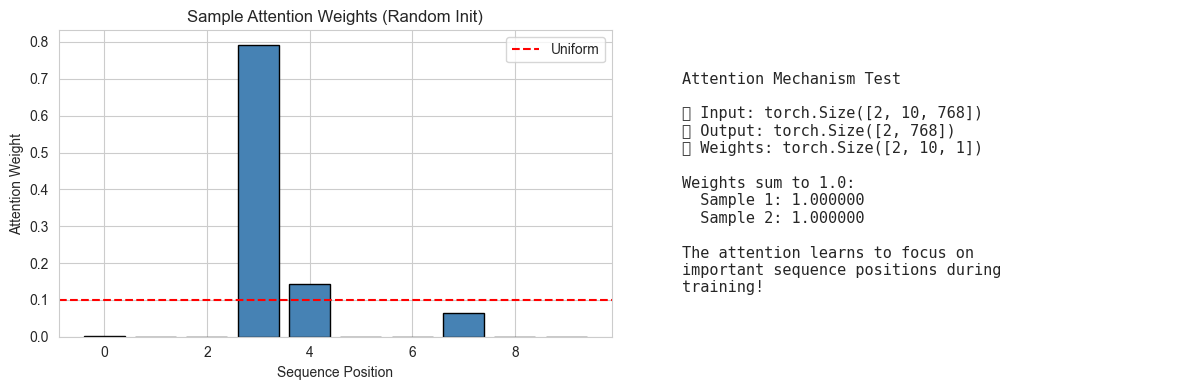

✅ Attention mechanism works correctly!


In [14]:
# Test attention module
print("🧪 Testing Attention Mechanism...")
test_attention = AdditiveAttention(input_dim=768, query_dim=200)
test_input = torch.randn(2, 10, 768)  # batch=2, seq_len=10, dim=768
test_mask = torch.ones(2, 10)  # No padding

test_output, test_weights = test_attention(test_input, test_mask)

print(f"  Input shape: {test_input.shape} -> (batch, sequence_length, embedding_dim)")
print(f"  Output shape: {test_output.shape} -> (batch, embedding_dim)")
print(f"  Attention weights shape: {test_weights.shape} -> (batch, sequence_length, 1)")

# Visualize attention weights for first sample
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
weights_np = test_weights[0].squeeze().detach().numpy()
plt.bar(range(len(weights_np)), weights_np, color='steelblue', edgecolor='black')
plt.xlabel('Sequence Position')
plt.ylabel('Attention Weight')
plt.title('Sample Attention Weights (Random Init)')
plt.axhline(y=1/len(weights_np), color='r', linestyle='--', label='Uniform')
plt.legend()

plt.subplot(1, 2, 2)
plt.text(0.1, 0.5, f"""
Attention Mechanism Test

✅ Input: {test_input.shape}
✅ Output: {test_output.shape}
✅ Weights: {test_weights.shape}

Weights sum to 1.0:
  Sample 1: {test_weights[0].sum().item():.6f}
  Sample 2: {test_weights[1].sum().item():.6f}

The attention learns to focus on
important sequence positions during
training!
""", fontsize=11, verticalalignment='center', family='monospace')
plt.axis('off')

plt.tight_layout()
plt.show()

print("✅ Attention mechanism works correctly!")


#### Mean Pooling

In [15]:
# class MeanPooling(nn.Module):
#     """
#     Simple mean pooling layer that averages embeddings across sequence dimension
    
#     This is an alternative to attention pooling - instead of learning which
#     positions to focus on, it simply takes the average of all positions.
#     """
#     def __init__(self):
#         super().__init__()
        
#     def forward(self, embeddings, attention_mask=None):
#         """
#         Args:
#             embeddings: (batch, seq_len, embedding_dim) - Input embeddings
#             attention_mask: (batch, seq_len) - 1 for real tokens, 0 for padding
#         Returns:
#             pooled: (batch, embedding_dim) - Mean pooled representation
#         """
#         if attention_mask is not None:
#             # Mask out padding tokens by setting them to 0
#             embeddings = embeddings * attention_mask.unsqueeze(-1)
#             # Calculate mean only over non-padding tokens
#             seq_lengths = attention_mask.sum(dim=1, keepdim=True)  # (batch, 1)
#             pooled = embeddings.sum(dim=1) / seq_lengths  # (batch, embedding_dim)
#         else:
#             # Simple mean across sequence dimension
#             pooled = embeddings.mean(dim=1)  # (batch, embedding_dim)
            
#         return pooled

# print("✅ MeanPooling module defined")

### Step 2: News Encoder

Converts a news title into a vector representation using BERT + Attention.


In [16]:
class NewsEncoder(nn.Module):
    """
    Encodes news article titles into fixed-size vectors
    
    Architecture:
      Title Text → BERT → Word Embeddings → Attention Pooling → News Vector
    """
    def __init__(self, config):
        super().__init__()
        self.embedding = AutoModel.from_pretrained(config['MODEL_NAME'])
        self.attention_pooling = AdditiveAttention(
            config['EMBEDDING_DIM'], 
            config['ATTENTION_QUERY_DIM']
        )
        
    def forward(self, input_ids, attention_mask):
        """
        Args:
            input_ids: (batch, seq_len) - Tokenized text
            attention_mask: (batch, seq_len) - 1 for real tokens, 0 for padding
        Returns:
            news_vector: (batch, embedding_dim) - News representation
        """
        # Get BERT embeddings for all words
        outputs = self.embedding(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state  # (batch, seq_len, 768)
        
        # Use attention to aggregate word embeddings
        news_vector, _ = self.attention_pooling(last_hidden_state, attention_mask)
        
        return news_vector

print("✅ NewsEncoder module defined")


✅ NewsEncoder module defined


### Step 3: Complete News Recommender Model

Combines News Encoder and User Encoder for click prediction.


In [17]:
class NewsRecommender(nn.Module):
    """
    Complete News Recommendation Model
    
    Architecture:
      1. News Encoder: Encodes all news (history + candidates)
      2. User Encoder: Aggregates history news with attention
      3. Click Predictor: Dot product between user and candidate vectors
    """
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Shared news encoder for all news articles
        self.news_encoder = NewsEncoder(config)
        
        # User encoder: attention over historical news
        self.user_attention = AdditiveAttention(
            config['EMBEDDING_DIM'], 
            config['ATTENTION_QUERY_DIM']
        )
        
    def forward(self, history_input_ids, history_attn_mask, 
                candidate_input_ids, candidate_attn_mask):
        """
        Args:
            history_input_ids: (batch, hist_len, seq_len)
            history_attn_mask: (batch, hist_len, seq_len)
            candidate_input_ids: (batch, num_candidates, seq_len)
            candidate_attn_mask: (batch, num_candidates, seq_len)
        Returns:
            scores: (batch, num_candidates) - Click prediction scores
        """
        batch_size = history_input_ids.size(0)
        
        # === 1. Encode History ===
        # Flatten: (batch * hist_len, seq_len)
        hist_flat_input = history_input_ids.view(-1, self.config['MAX_TITLE_LEN'])
        hist_flat_mask = history_attn_mask.view(-1, self.config['MAX_TITLE_LEN'])
        
        # Encode all history news
        hist_vecs = self.news_encoder(hist_flat_input, hist_flat_mask)
        
        # Reshape: (batch, hist_len, embedding_dim)
        hist_vecs = hist_vecs.view(batch_size, self.config['MAX_HISTORY_LEN'], -1)
        
        # Create mask for history pooling (which history slots are real vs padding)
        hist_pool_mask = (history_attn_mask.sum(dim=2) > 0).long()
        
        # Aggregate history into user vector
        user_vector, _ = self.user_attention(hist_vecs, hist_pool_mask)
        
        # === 2. Encode Candidates ===
        num_candidates = candidate_input_ids.size(1)
        
        # Flatten: (batch * num_candidates, seq_len)
        cand_flat_input = candidate_input_ids.view(-1, self.config['MAX_TITLE_LEN'])
        cand_flat_mask = candidate_attn_mask.view(-1, self.config['MAX_TITLE_LEN'])
        
        # Encode all candidates
        cand_vecs = self.news_encoder(cand_flat_input, cand_flat_mask)
        
        # Reshape: (batch, num_candidates, embedding_dim)
        cand_vecs = cand_vecs.view(batch_size, num_candidates, -1)
        
        # === 3. Click Prediction ===
        # Dot product: user_vector · candidate_vector
        # (batch, num_candidates, embedding_dim) @ (batch, embedding_dim, 1)
        scores = torch.bmm(cand_vecs, user_vector.unsqueeze(-1)).squeeze(-1)
        
        return scores

print("✅ NewsRecommender model defined")


✅ NewsRecommender model defined


## 📦 Create PyTorch Dataset and DataLoader


In [18]:
class NewsDataset(Dataset):
    """PyTorch Dataset for news recommendation"""
    def __init__(self, samples, news_features, config):
        self.samples = samples
        self.news_features = news_features
        self.config = config
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Process history
        history_ids = sample['history']
        # Pad if shorter than max length
        if len(history_ids) < self.config['MAX_HISTORY_LEN']:
            history_ids = history_ids + ['<PAD>'] * (self.config['MAX_HISTORY_LEN'] - len(history_ids))
        
        # Stack history features
        hist_input_ids = torch.cat([
            self.news_features.get(nid, self.news_features['<PAD>'])['input_ids'] 
            for nid in history_ids
        ])
        hist_attn_mask = torch.cat([
            self.news_features.get(nid, self.news_features['<PAD>'])['attention_mask'] 
            for nid in history_ids
        ])
        
        # Process candidates
        candidate_ids = sample['candidates']
        cand_input_ids = torch.cat([
            self.news_features.get(nid, self.news_features['<PAD>'])['input_ids'] 
            for nid in candidate_ids
        ])
        cand_attn_mask = torch.cat([
            self.news_features.get(nid, self.news_features['<PAD>'])['attention_mask'] 
            for nid in candidate_ids
        ])
        
        return {
            'history_input_ids': hist_input_ids,
            'history_attn_mask': hist_attn_mask,
            'candidate_input_ids': cand_input_ids,
            'candidate_attn_mask': cand_attn_mask,
            'label': torch.tensor(sample['label'], dtype=torch.long)
        }

# Create datasets
print("📦 Creating PyTorch datasets...")
train_dataset = NewsDataset(train_samples, news_features, config)
val_dataset = NewsDataset(val_samples, news_features, config)

print(f"✅ Train dataset: {len(train_dataset):,} samples")
print(f"✅ Validation dataset: {len(val_dataset):,} samples")

# Create dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config['BATCH_SIZE'], 
    shuffle=True,
    num_workers=0  # Set to 0 to avoid multiprocessing issues
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,  # Variable number of candidates per sample
    shuffle=False,
    num_workers=0
)

print(f"✅ Train batches: {len(train_loader)}")
print(f"✅ Validation batches: {len(val_loader)}")


📦 Creating PyTorch datasets...
✅ Train dataset: 717 samples
✅ Validation dataset: 500 samples
✅ Train batches: 23
✅ Validation batches: 500


## 🎓 Training Functions


In [19]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    batch_losses = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        # Move to device
        hist_ids = batch['history_input_ids'].to(device)
        hist_mask = batch['history_attn_mask'].to(device)
        cand_ids = batch['candidate_input_ids'].to(device)
        cand_mask = batch['candidate_attn_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        scores = model(hist_ids, hist_mask, cand_ids, cand_mask)
        
        # Compute loss
        loss = criterion(scores, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        batch_loss = loss.item()
        total_loss += batch_loss
        batch_losses.append(batch_loss)
        
        # Update progress bar
        progress_bar.set_postfix({'loss': f'{batch_loss:.4f}'})
    
    avg_loss = total_loss / len(dataloader)
    return avg_loss, batch_losses


def calculate_mrr(y_true, y_score, k=10):
    """
    Calculate Mean Reciprocal Rank
    
    Args:
        y_true: Ground truth labels (1 for relevant, 0 for not)
        y_score: Predicted scores
        k: Consider only top-k items
    
    Returns:
        MRR score
    """
    # Get top-k predictions
    top_k_idx = np.argsort(y_score)[::-1][:k]
    
    # Find first relevant item in top-k
    for i, idx in enumerate(top_k_idx):
        if y_true[idx] == 1:
            return 1.0 / (i + 1)
    
    return 0.0


def calculate_ndcg(y_true, y_score, k=10):
    """
    Calculate Normalized Discounted Cumulative Gain
    
    Args:
        y_true: Ground truth labels
        y_score: Predicted scores
        k: Consider only top-k items
    
    Returns:
        NDCG@k score
    """
    def dcg_at_k(r, k):
        """Discounted Cumulative Gain"""
        r = np.asfarray(r)[:k]
        if r.size:
            return np.sum((2**r - 1) / np.log2(np.arange(2, r.size + 2)))
        return 0.
    
    # Sort by predicted scores
    top_k_idx = np.argsort(y_score)[::-1][:k]
    r = [y_true[i] for i in top_k_idx]
    
    # Calculate DCG
    dcg = dcg_at_k(r, k)
    
    # Calculate IDCG (ideal DCG - sorted by true relevance)
    ideal_r = sorted(y_true, reverse=True)
    idcg = dcg_at_k(ideal_r, k)
    
    if idcg == 0:
        return 0.
    
    return dcg / idcg


def evaluate_with_ranking_metrics(model, dataloader, device, k_values=[5, 10]):
    """
    Evaluate model with AUC, MRR, and NDCG
    
    Args:
        model: The recommendation model
        dataloader: Validation dataloader
        device: Device to run on
        k_values: List of k values for MRR@k and NDCG@k
    
    Returns:
        Dictionary with all metrics
    """
    model.eval()
    
    # For overall metrics (treating as binary classification)
    all_labels = []
    all_scores = []
    
    # For ranking metrics (per impression)
    mrr_scores = {k: [] for k in k_values}
    ndcg_scores = {k: [] for k in k_values}
    
    with torch.no_grad():
        # Group by impression_id if your data has that structure
        # Otherwise, evaluate on batches
        for batch in tqdm(dataloader, desc="Evaluating"):
            hist_ids = batch['history_input_ids'].to(device)
            hist_mask = batch['history_attn_mask'].to(device)
            cand_ids = batch['candidate_input_ids'].to(device)
            cand_mask = batch['candidate_attn_mask'].to(device)
            labels = batch['label'].numpy()
            
            # Forward pass
            scores = model(hist_ids, hist_mask, cand_ids, cand_mask)
            scores = scores.cpu().numpy().flatten()
            
            # Collect for AUC
            all_scores.extend(scores)
            all_labels.extend(labels.flatten())
            
            # Calculate ranking metrics per batch
            # Note: For proper MRR/NDCG, you should group by impression
            # This is a simplified version
            for k in k_values:
                mrr_scores[k].append(calculate_mrr(labels.flatten(), scores, k=k))
                ndcg_scores[k].append(calculate_ndcg(labels.flatten(), scores, k=k))
    
    # Calculate final metrics
    try:
        auc = roc_auc_score(all_labels, all_scores)
    except:
        auc = 0.5
    
    metrics = {
        'auc': auc,
    }
    
    for k in k_values:
        metrics[f'mrr@{k}'] = np.mean(mrr_scores[k])
        metrics[f'ndcg@{k}'] = np.mean(ndcg_scores[k])
    
    return metrics

print("✅ Ranking metrics functions defined")


✅ Ranking metrics functions defined


## 🚀 Initialize Model and Training


In [20]:
print("🚀 Initializing model...")
model = NewsRecommender(config).to(config['DEVICE'])

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Model initialized on {config['DEVICE']}")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")

# Initialize optimizer and loss
optimizer = torch.optim.AdamW(model.parameters(), lr=config['LR'])
criterion = nn.CrossEntropyLoss()

print(f"✅ Optimizer: AdamW (lr={config['LR']})")
print(f"✅ Loss function: CrossEntropyLoss")


🚀 Initializing model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model initialized on mps
   Total parameters: 124,953,632
   Trainable parameters: 124,953,632
✅ Optimizer: AdamW (lr=4e-05)
✅ Loss function: CrossEntropyLoss


## 🎯 Train the Model


In [21]:
checkpoint_path = "news_rec_model_latest.pth"

# Check if we should load from checkpoint
if config['LOAD_CHECKPOINT'] and os.path.exists(checkpoint_path):
    print(f"📂 Loading checkpoint from {checkpoint_path}...")
    model.load_state_dict(torch.load(checkpoint_path, map_location=config['DEVICE']))
    print("✅ Model loaded successfully!")

    val_metrics = evaluate_with_ranking_metrics(model, val_loader, config['DEVICE'], k_values=[5, 10])

    print(f"📊 Validation Metrics:")
    print(f"  AUC: {val_metrics['auc']:.4f}")
    print(f"  MRR@5: {val_metrics['mrr@5']:.4f}")
    print(f"  MRR@10: {val_metrics['mrr@10']:.4f}")
    print(f"  NDCG@5: {val_metrics['ndcg@5']:.4f}")
    print(f"  NDCG@10: {val_metrics['ndcg@10']:.4f}")

else:
    print("="*80)
    print(f"🎓 TRAINING FOR {config['EPOCHS']} EPOCHS")
    print("="*80)

    history = {
        'train_loss': [],
        'val_auc': [],
        'epoch': []
    }

    for epoch in range(config['EPOCHS']):
        print(f"\n")
        print(f"📍 Epoch {epoch+1}/{config['EPOCHS']}")
        print(f"{'='*80}")

        # Train
        avg_loss, batch_losses = train_epoch(model, train_loader, optimizer, criterion, config['DEVICE'])
        print(f"✅ Training Loss: {avg_loss:.4f}")

        val_metrics = evaluate_with_ranking_metrics(model, val_loader, config['DEVICE'], k_values=[5, 10])

        print(f"📊 Validation Metrics:")
        print(f"  AUC: {val_metrics['auc']:.4f}")
        print(f"  MRR@5: {val_metrics['mrr@5']:.4f}")
        print(f"  MRR@10: {val_metrics['mrr@10']:.4f}")
        print(f"  NDCG@5: {val_metrics['ndcg@5']:.4f}")
        print(f"  NDCG@10: {val_metrics['ndcg@10']:.4f}")

        # Save checkpoint
        torch.save(model.state_dict(), checkpoint_path)
        print(f"💾 Model saved to {checkpoint_path}")

        # Record history
        history['train_loss'].append(avg_loss)
        # history['val_auc'].append(val_auc)
        history['epoch'].append(epoch + 1)

    print("\n" + "="*80)
    print("🎉 TRAINING COMPLETE!")
    print("="*80)
    print(f"Final Training Loss: {history['train_loss'][-1]:.4f}")
    print("="*80)


📂 Loading checkpoint from news_rec_model_latest.pth...
✅ Model loaded successfully!


Evaluating: 100%|██████████| 500/500 [00:32<00:00, 15.17it/s]

📊 Validation Metrics:
  AUC: 0.6774
  MRR@5: 0.2989
  MRR@10: 0.3226
  NDCG@5: 0.3261
  NDCG@10: 0.3900


## 🔍 Visualize Predictions

Let's see how the model makes predictions!


In [22]:
def visualize_prediction(model, dataset, tokenizer, device, sample_idx=0):
    """Visualize model prediction for a specific sample"""
    model.eval()
    
    # Get sample
    batch = dataset[sample_idx]
    
    # Move to device and add batch dimension
    hist_ids = batch['history_input_ids'].unsqueeze(0).to(device)
    hist_mask = batch['history_attn_mask'].unsqueeze(0).to(device)
    cand_ids = batch['candidate_input_ids'].unsqueeze(0).to(device)
    cand_mask = batch['candidate_attn_mask'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        scores = model(hist_ids, hist_mask, cand_ids, cand_mask)
        probs = F.softmax(scores, dim=1).squeeze(0).cpu().numpy()
    
    # Decode history
    history_text = []
    for j in range(hist_ids.shape[1]):
        if hist_mask[0, j].sum() == 0:
            continue
        toks = hist_ids[0, j].cpu().numpy()
        text = tokenizer.decode(toks, skip_special_tokens=True)
        if text:  # Skip empty
            history_text.append(text)
    
    # Decode candidates
    candidates_text = []
    for k in range(cand_ids.shape[1]):
        toks = cand_ids[0, k].cpu().numpy()
        text = tokenizer.decode(toks, skip_special_tokens=True)
        candidates_text.append(text)
    
    # Visualize
    print("="*100)
    print(f"🔍 PREDICTION VISUALIZATION - Sample {sample_idx}")
    print("="*100)
    
    print(f"\n📚 USER HISTORY ({len(history_text)} articles):")
    for i, text in enumerate(history_text[-5:], 1):  # Show last 5
        print(f"  {i}. {text}")
    if len(history_text) > 5:
        print(f"  ... and {len(history_text) - 5} more")
    
    print(f"\n🎯 CANDIDATES & MODEL PREDICTIONS:")
    
    # Create visualization data
    candidate_data = []
    for k, text in enumerate(candidates_text):
        is_clicked = (k == batch['label'].item())
        prob = probs[k]
        candidate_data.append({
            'text': text,
            'prob': prob,
            'is_clicked': is_clicked,
            'rank': k
        })
    
    # Sort by probability
    candidate_data.sort(key=lambda x: x['prob'], reverse=True)
    
    for i, cand in enumerate(candidate_data, 1):
        prob_bar = '█' * int(cand['prob'] * 50)
        status = "✅ ACTUALLY CLICKED" if cand['is_clicked'] else "❌ NOT CLICKED"
        print(f"  Rank {i}: {cand['prob']*100:5.1f}% {prob_bar}")
        print(f"         {status}")
        print(f"         {cand['text']}")
        print()
    
    # Show if model got it right
    top_prediction = candidate_data[0]
    if top_prediction['is_clicked']:
        print("🎉 ✅ MODEL CORRECT: Top prediction matches actual click!")
    else:
        actual_rank = next(i for i, c in enumerate(candidate_data, 1) if c['is_clicked'])
        print(f"❌ MODEL INCORRECT: Actual click ranked #{actual_rank}")
    
    print("="*100)
    
    # Plot probabilities
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['green' if c['is_clicked'] else 'steelblue' for c in candidate_data]
    y_pos = np.arange(len(candidate_data))
    ax.barh(y_pos, [c['prob'] for c in candidate_data], color=colors, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"Rank {i}" for i in range(1, len(candidate_data)+1)])
    ax.set_xlabel('Predicted Click Probability')
    ax.set_title('Model Predictions (Green = Actually Clicked)')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

print("✅ Visualization function defined")


✅ Visualization function defined


### 📊 Visualize Multiple Predictions


🔍 PREDICTION VISUALIZATION - Sample 488

📚 USER HISTORY (13 articles):
  1. Trump records 'strongly corroborate' sex assault claims, accuser says
  2. Nearly $400M worth of cocaine and marijuana intercepted by US Coast Guard
  3. Amelia Bambridge: Body of missing backpacker found in sea
  4. Donald Trump Jr. reflects on explosive 'View' chat: 'I don't think they like me much anymore'
  5. This Is The Moment A Senior Shelter Dog Knew He Was Safe
  ... and 8 more

🎯 CANDIDATES & MODEL PREDICTIONS:
  Rank 1:  61.5% ██████████████████████████████
         ✅ ACTUALLY CLICKED
         Charles Rogers, former Michigan State football, Detroit Lions star, dead at 38

  Rank 2:  14.1% ███████
         ❌ NOT CLICKED
         Mixed-race mother reveals strangers question whether she's related to her fair-skinned daughter - including a suspicious church

  Rank 3:  13.3% ██████
         ❌ NOT CLICKED
         Nikki Haley claims top aides tried to recruit her to 'save the country' by undermining Trump

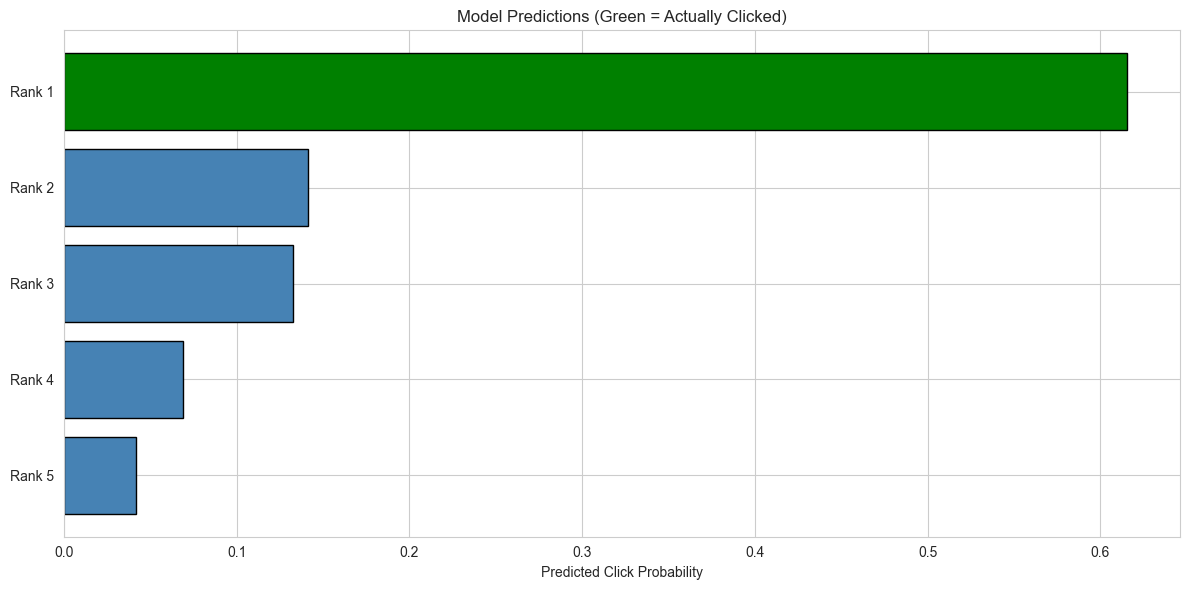

🔍 PREDICTION VISUALIZATION - Sample 266

📚 USER HISTORY (20 articles):
  1. Report: Ezekiel Elliott's dad investigated after police shoot wild cat near his home
  2. 'The Office' star Jenna Fischer responds to Chrissy Teigen's theory that Jim and Pam are divorced
  3. 'Time was of the essence': Politicians add to reward for missing 3-year-old
  4. A former Nazi bunker in Germany is being turned into a luxury hotel with a 5-storey roof garden
  5. Science Says Doing This One Thing for 15 Minutes Is as Beneficial as a Vacation Day
  ... and 15 more

🎯 CANDIDATES & MODEL PREDICTIONS:
  Rank 1:  33.3% ████████████████
         ❌ NOT CLICKED
         Dramatic Footage Shows Plane Skidding Off Runway at O'Hare Airport in Chicago

  Rank 2:  28.6% ██████████████
         ❌ NOT CLICKED
         Eerie photos of an abandoned airport that hasn't been touched in 25 years

  Rank 3:  26.2% █████████████
         ✅ ACTUALLY CLICKED
         How horsepower is measured in cars

  Rank 4:   8.5% ████
  

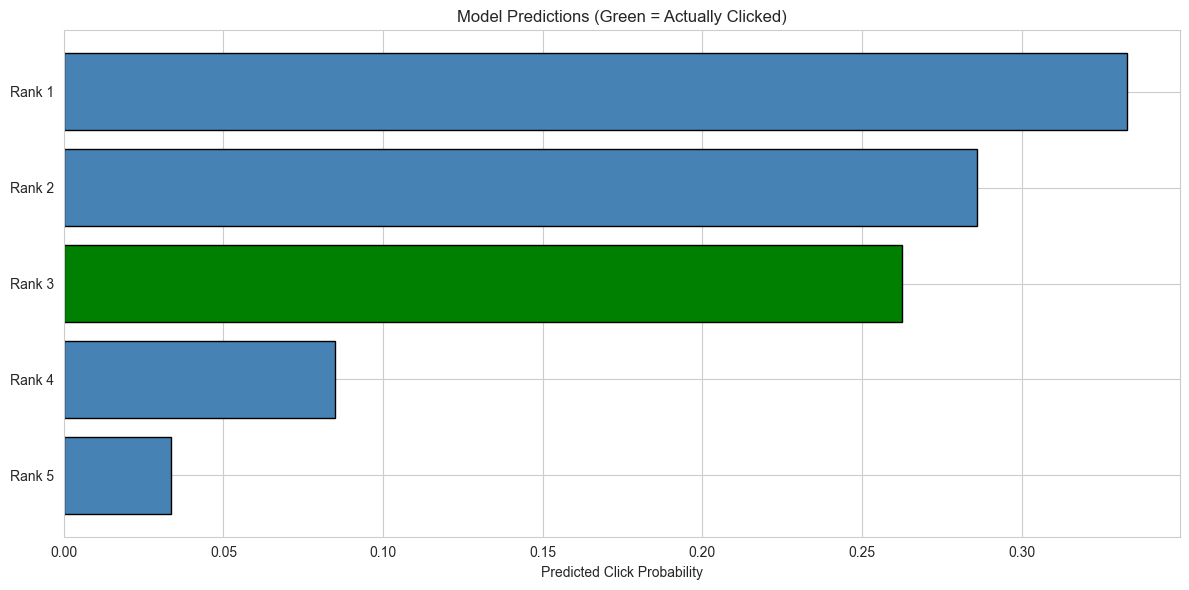

🔍 PREDICTION VISUALIZATION - Sample 16

📚 USER HISTORY (20 articles):
  1. Chris Paul receives standing ovation in return to Houston against Rockets
  2. Whoopi Goldberg Asks Meghan McCain to 'Respect' Her 'View' Co-Hosts During
  3. Kevin Spacey Won't Be Charged in Sexual Assault Case After Accuser Dies
  4. What recent history tells us to expect from World Series Game 7
  5. Former Federal Prosecutor Says Lori Loughlin's Daughters Could Be Charged in College Scandal
  ... and 15 more

🎯 CANDIDATES & MODEL PREDICTIONS:
  Rank 1:  27.9% █████████████
         ❌ NOT CLICKED
         Demi Lovato debuts new boyfriend, plus more celeb love life news for mid-November 2019

  Rank 2:  19.2% █████████
         ✅ ACTUALLY CLICKED
         Video shows a Boeing 737 plane carrying 196 people burst into flames just after landing at an Egyptian airport

  Rank 3:  18.8% █████████
         ❌ NOT CLICKED
         Lamar Odom is Engaged to Girlfriend Sabrina Parr -- See Her Stunning Ring!

  Rank 4:  1

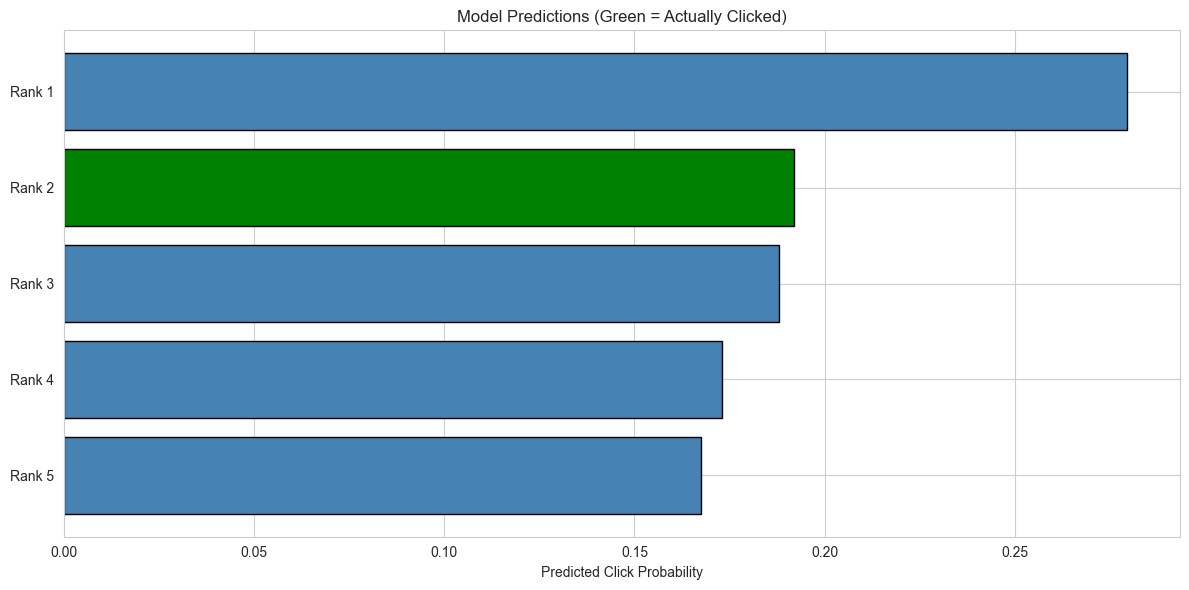

In [23]:
# Visualize predictions on a few samples
num_samples = 3

for i in range(num_samples):
    sample_idx = random.randint(0, len(train_dataset) - 1)
    visualize_prediction(model, train_dataset, tokenizer, config['DEVICE'], sample_idx)


## 🎨 Advanced Visualization: Embedding Space

Let's visualize the news embeddings in 2D space using PCA!


🎨 Computing embeddings for 100 random news articles...


Encoding: 100%|██████████| 100/100 [00:00<00:00, 138.83it/s]


✅ Computed 100 embeddings of dimension 768
🔄 Reducing to 2D using PCA...
✅ PCA explained variance: 67.36%


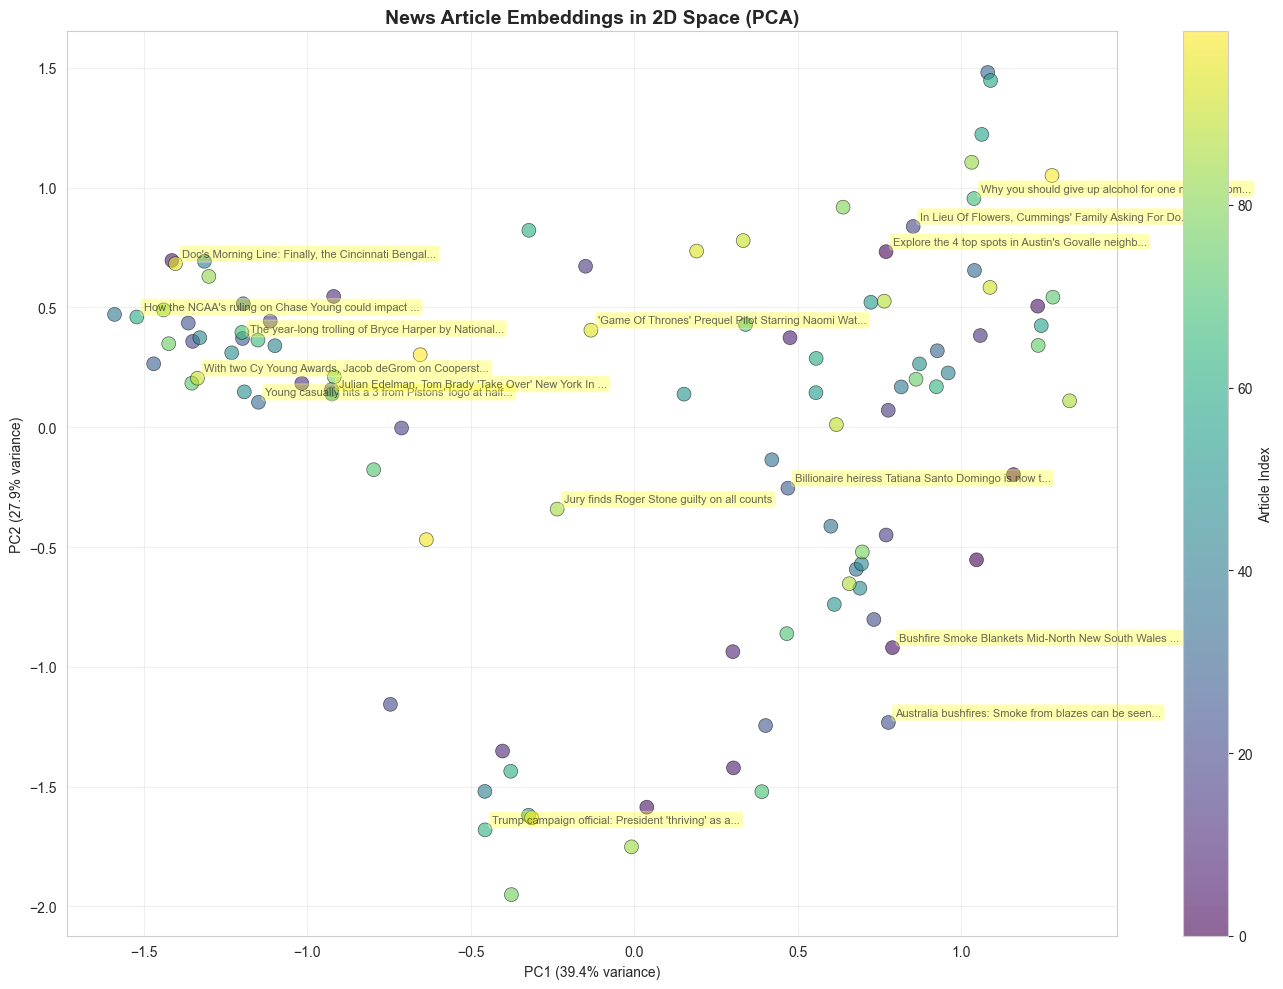

✅ Visualization complete!


In [24]:
def visualize_embedding_space(model, news_df, news_features, device, num_articles=100):
    """Visualize news embeddings in 2D using PCA"""
    model.eval()
    
    print(f"🎨 Computing embeddings for {num_articles} random news articles...")
    
    # Sample random articles
    sample_articles = news_df.sample(n=min(num_articles, len(news_df)))
    
    embeddings = []
    titles = []
    
    with torch.no_grad():
        for _, row in tqdm(sample_articles.iterrows(), total=len(sample_articles), desc="Encoding"):
            nid = row['news_id']
            title = row['title']
            
            if nid in news_features:
                features = news_features[nid]
                input_ids = features['input_ids'].to(device)
                attention_mask = features['attention_mask'].to(device)
                
                # Get embedding
                embedding = model.news_encoder(input_ids, attention_mask)
                embeddings.append(embedding.cpu().numpy().flatten())
                titles.append(title)
    
    embeddings = np.array(embeddings)
    
    print(f"✅ Computed {len(embeddings)} embeddings of dimension {embeddings.shape[1]}")
    print("🔄 Reducing to 2D using PCA...")
    
    # Apply PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    print(f"✅ PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")
    
    # Plot
    plt.figure(figsize=(14, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         alpha=0.6, s=100, c=range(len(embeddings_2d)), 
                         cmap='viridis', edgecolors='black', linewidth=0.5)
    
    # Annotate some random points
    num_annotate = min(15, len(titles))
    indices = random.sample(range(len(titles)), num_annotate)
    
    for idx in indices:
        # Truncate long titles
        label = titles[idx][:50] + '...' if len(titles[idx]) > 50 else titles[idx]
        plt.annotate(label, 
                    xy=(embeddings_2d[idx, 0], embeddings_2d[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))
    
    plt.colorbar(scatter, label='Article Index')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('News Article Embeddings in 2D Space (PCA)', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualization complete!")

# Run visualization
visualize_embedding_space(model, news_df, news_features, config['DEVICE'], num_articles=100)


## 📈 Model Performance Summary


In [25]:
print("="*80)
print("📊 FINAL MODEL SUMMARY")
print("="*80)
print(f"\n🏗️ Architecture:")
print(f"  News Encoder: {config['MODEL_NAME']}")
print(f"  Embedding Dimension: {config['EMBEDDING_DIM']}")
print(f"  Attention Query Dimension: {config['ATTENTION_QUERY_DIM']}")
print(f"\n📊 Dataset:")
print(f"  News Articles: {len(news_df):,}")
print(f"  Training Samples: {len(train_dataset):,}")
print(f"  Validation Samples: {len(val_dataset):,}")
print(f"\n⚙️ Training Config:")
print(f"  Epochs: {config['EPOCHS']}")
print(f"  Batch Size: {config['BATCH_SIZE']}")
print(f"  Learning Rate: {config['LR']}")
print(f"  Max History Length: {config['MAX_HISTORY_LEN']}")
print(f"  Negative Samples: {config['NEG_SAMPLES']}")
print(f"\n💾 Model saved to: {checkpoint_path}")
print("="*80)


📊 FINAL MODEL SUMMARY

🏗️ Architecture:
  News Encoder: roberta-base
  Embedding Dimension: 768
  Attention Query Dimension: 200

📊 Dataset:
  News Articles: 65,238
  Training Samples: 717
  Validation Samples: 500

⚙️ Training Config:
  Epochs: 3
  Batch Size: 32
  Learning Rate: 4e-05
  Max History Length: 20
  Negative Samples: 4

💾 Model saved to: news_rec_model_latest.pth


## 🎯 Interactive Prediction Tool

Use this to test the model on any sample!


🔍 PREDICTION VISUALIZATION - Sample 42

📚 USER HISTORY (0 articles):

🎯 CANDIDATES & MODEL PREDICTIONS:
  Rank 1:  44.0% █████████████████████
         ❌ NOT CLICKED
         Porsche launches into second story of New Jersey building, killing 2

  Rank 2:  28.6% ██████████████
         ✅ ACTUALLY CLICKED
         Marlboro Man Bob Norris dies at 90, having reportedly never been a smoker

  Rank 3:  18.2% █████████
         ❌ NOT CLICKED
         Lance Altimeter Is A Delicious Drop-In Truck Camper Debuting At SEMA

  Rank 4:   4.6% ██
         ❌ NOT CLICKED
         Cook leads Vikings to 28-24 prime-time road win over Cowboys

  Rank 5:   4.6% ██
         ❌ NOT CLICKED
         The Tiny Hair Detail We Almost Missed in Storm Reid's People's Choice Awards Look

❌ MODEL INCORRECT: Actual click ranked #2


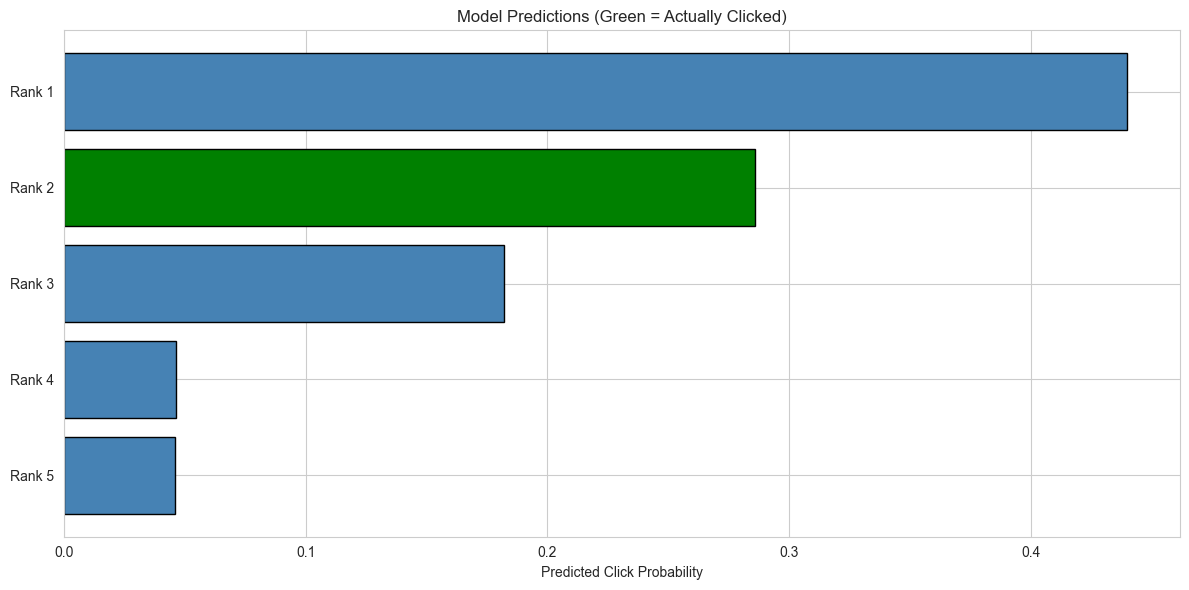

In [26]:
# Try different samples by changing this index
SAMPLE_INDEX = 42  # Change this to explore different predictions!

visualize_prediction(model, train_dataset, tokenizer, config['DEVICE'], SAMPLE_INDEX)


## Data Analysis

In [27]:
## 📊 COMPREHENSIVE DATASET ANALYSIS

### Load Full News Data with Categories
print("📰 Loading full news data with categories...")

# Load news with all relevant columns
news_full_train = pd.read_csv(config['NEWS_TRAIN_PATH'], sep='\t', header=None,
                               names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
news_full_val = pd.read_csv(config['NEWS_VAL_PATH'], sep='\t', header=None,
                             names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])

# Combine and deduplicate
news_full = pd.concat([news_full_train, news_full_val]).drop_duplicates(subset=['news_id'])
print(f"✅ Loaded {len(news_full):,} unique news articles with full metadata")

# Create news_id to category/subcategory mappings
news_to_category = news_full.set_index('news_id')['category'].to_dict()
news_to_subcategory = news_full.set_index('news_id')['subcategory'].to_dict()

📰 Loading full news data with categories...
✅ Loaded 65,238 unique news articles with full metadata


📊 1. CATEGORY DISTRIBUTION ANALYSIS


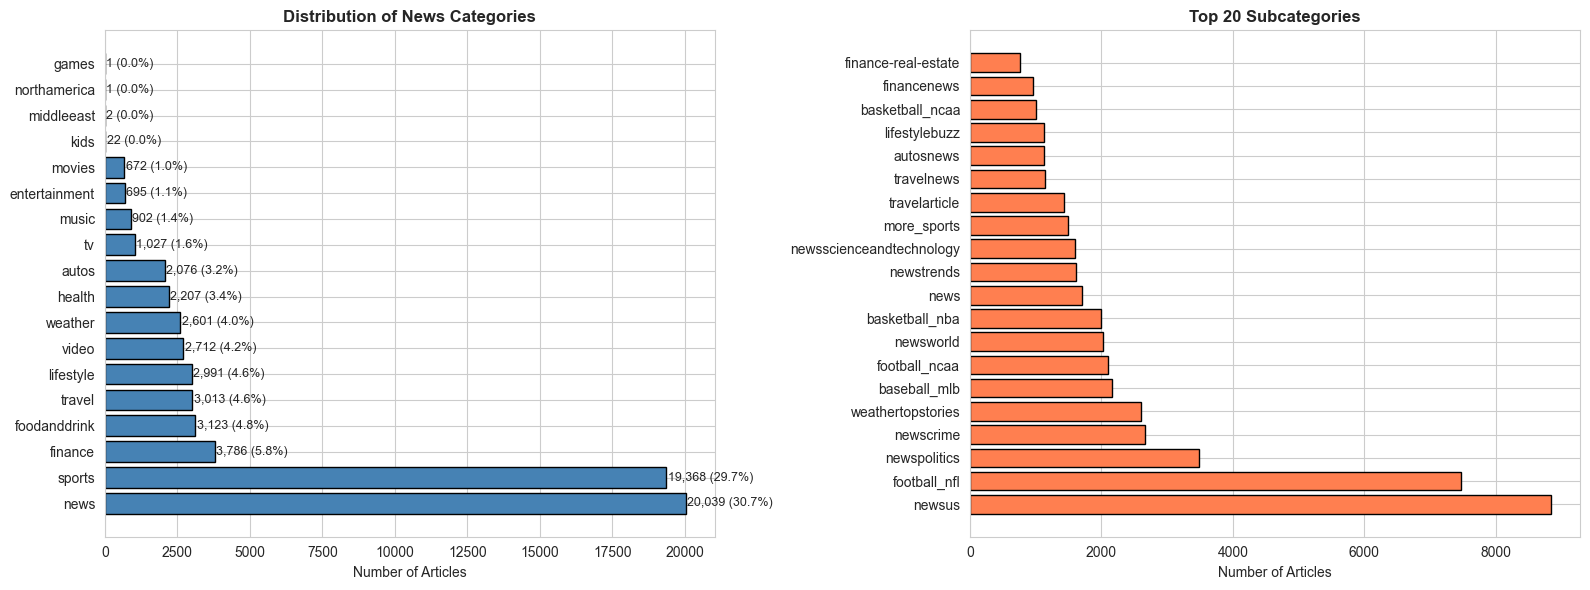


📋 Category Summary:
  Total categories: 18
  Total subcategories: 270

🔝 Top 5 Categories:
  news: 20,039 articles (30.7%)
  sports: 19,368 articles (29.7%)
  finance: 3,786 articles (5.8%)
  foodanddrink: 3,123 articles (4.8%)
  travel: 3,013 articles (4.6%)


In [28]:
### 📊 1. Category Distribution Analysis
print("="*80)
print("📊 1. CATEGORY DISTRIBUTION ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Category distribution
category_counts = news_full['category'].value_counts()
axes[0].barh(category_counts.index, category_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Number of Articles')
axes[0].set_title('Distribution of News Categories', fontsize=12, fontweight='bold')
for i, v in enumerate(category_counts.values):
    axes[0].text(v + 50, i, f'{v:,} ({v/len(news_full)*100:.1f}%)', va='center', fontsize=9)

# Top 20 subcategories
subcategory_counts = news_full['subcategory'].value_counts().head(20)
axes[1].barh(subcategory_counts.index, subcategory_counts.values, color='coral', edgecolor='black')
axes[1].set_xlabel('Number of Articles')
axes[1].set_title('Top 20 Subcategories', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📋 Category Summary:")
print(f"  Total categories: {news_full['category'].nunique()}")
print(f"  Total subcategories: {news_full['subcategory'].nunique()}")
print(f"\n🔝 Top 5 Categories:")
for cat, count in category_counts.head(5).items():
    print(f"  {cat}: {count:,} articles ({count/len(news_full)*100:.1f}%)")

In [29]:
### 📊 2. Behavior Parsing with Category Info
print("="*80)
print("📊 2. PARSING USER BEHAVIORS WITH CATEGORY INFO")
print("="*80)

# Load full behaviors
behaviors_full = pd.read_csv(config['BEHAVIORS_TRAIN_PATH'], sep='\t', header=None,
                              names=['impression_id', 'user_id', 'time', 'history', 'impressions'])
print(f"Total behaviors: {len(behaviors_full):,}")

def parse_behavior_with_categories(row, news_to_cat, news_to_subcat):
    """Parse a behavior row and extract category information"""
    history_str = str(row['history'])
    impressions_str = str(row['impressions'])
    
    # Parse history
    history_ids = history_str.split() if history_str != 'nan' else []
    history_categories = [news_to_cat.get(nid, 'unknown') for nid in history_ids]
    history_subcategories = [news_to_subcat.get(nid, 'unknown') for nid in history_ids]
    
    # Parse impressions
    clicked_categories = []
    clicked_subcategories = []
    non_clicked_categories = []
    non_clicked_subcategories = []
    
    for imp in impressions_str.split():
        nid, label = imp.split('-')
        cat = news_to_cat.get(nid, 'unknown')
        subcat = news_to_subcat.get(nid, 'unknown')
        
        if label == '1':
            clicked_categories.append(cat)
            clicked_subcategories.append(subcat)
        else:
            non_clicked_categories.append(cat)
            non_clicked_subcategories.append(subcat)
    
    return {
        'user_id': row['user_id'],
        'history_categories': history_categories,
        'history_subcategories': history_subcategories,
        'clicked_categories': clicked_categories,
        'clicked_subcategories': clicked_subcategories,
        'non_clicked_categories': non_clicked_categories,
        'non_clicked_subcategories': non_clicked_subcategories,
        'history_count': len(history_ids),
        'clicked_count': len(clicked_categories),
        'non_clicked_count': len(non_clicked_categories)
    }

# Parse all behaviors (use subset for speed if needed)
print("🔄 Parsing behaviors with category information...")
parsed_behaviors = []
for idx, row in tqdm(behaviors_full.iterrows(), total=len(behaviors_full), desc="Parsing"):
    parsed_behaviors.append(parse_behavior_with_categories(row, news_to_category, news_to_subcategory))

parsed_df = pd.DataFrame(parsed_behaviors)
print(f"✅ Parsed {len(parsed_df):,} user behaviors")

📊 2. PARSING USER BEHAVIORS WITH CATEGORY INFO
Total behaviors: 156,965
🔄 Parsing behaviors with category information...


Parsing: 100%|██████████| 156965/156965 [00:04<00:00, 33083.86it/s]


✅ Parsed 156,965 user behaviors


In [30]:
### 📊 3. KEY ANALYSIS: Do users click on articles matching their history?
print("="*80)
print("📊 3. CATEGORY MATCHING ANALYSIS")
print("="*80)
print("Question: Do users click on articles in the same category/subcategory as their history?")
print("="*80)

def calculate_category_match_rate(row, use_subcategory=False):
    """Calculate percentage of clicked items that match history categories"""
    if use_subcategory:
        history_set = set(row['history_subcategories'])
        clicked = row['clicked_subcategories']
        non_clicked = row['non_clicked_subcategories']
    else:
        history_set = set(row['history_categories'])
        clicked = row['clicked_categories']
        non_clicked = row['non_clicked_categories']
    
    if not history_set or history_set == {'unknown'}:
        return None, None
    
    # Calculate match rate for clicked items
    clicked_matches = sum(1 for cat in clicked if cat in history_set)
    clicked_rate = clicked_matches / len(clicked) if clicked else None
    
    # Calculate match rate for non-clicked items
    non_clicked_matches = sum(1 for cat in non_clicked if cat in history_set)
    non_clicked_rate = non_clicked_matches / len(non_clicked) if non_clicked else None
    
    return clicked_rate, non_clicked_rate

# Calculate match rates for both category and subcategory
print("🔄 Calculating category match rates...")
category_results = []
subcategory_results = []

for idx, row in parsed_df.iterrows():
    if row['history_count'] > 0 and row['clicked_count'] > 0:
        # Category level
        clicked_rate, non_clicked_rate = calculate_category_match_rate(row, use_subcategory=False)
        if clicked_rate is not None:
            category_results.append({
                'clicked_match_rate': clicked_rate,
                'non_clicked_match_rate': non_clicked_rate
            })
        
        # Subcategory level
        clicked_rate, non_clicked_rate = calculate_category_match_rate(row, use_subcategory=True)
        if clicked_rate is not None:
            subcategory_results.append({
                'clicked_match_rate': clicked_rate,
                'non_clicked_match_rate': non_clicked_rate
            })

category_df = pd.DataFrame(category_results)
subcategory_df = pd.DataFrame(subcategory_results)

print(f"\n📈 CATEGORY LEVEL RESULTS:")
print(f"  Average % of CLICKED items matching history categories: {category_df['clicked_match_rate'].mean()*100:.1f}%")
print(f"  Average % of NON-CLICKED items matching history categories: {category_df['non_clicked_match_rate'].mean()*100:.1f}%")
print(f"  Difference (Clicked - Non-clicked): {(category_df['clicked_match_rate'].mean() - category_df['non_clicked_match_rate'].mean())*100:.1f}%")

print(f"\n📈 SUBCATEGORY LEVEL RESULTS:")
print(f"  Average % of CLICKED items matching history subcategories: {subcategory_df['clicked_match_rate'].mean()*100:.1f}%")
print(f"  Average % of NON-CLICKED items matching history subcategories: {subcategory_df['non_clicked_match_rate'].mean()*100:.1f}%")
print(f"  Difference (Clicked - Non-clicked): {(subcategory_df['clicked_match_rate'].mean() - subcategory_df['non_clicked_match_rate'].mean())*100:.1f}%")

📊 3. CATEGORY MATCHING ANALYSIS
Question: Do users click on articles in the same category/subcategory as their history?
🔄 Calculating category match rates...

📈 CATEGORY LEVEL RESULTS:
  Average % of CLICKED items matching history categories: 77.8%
  Average % of NON-CLICKED items matching history categories: 69.8%
  Difference (Clicked - Non-clicked): 8.0%

📈 SUBCATEGORY LEVEL RESULTS:
  Average % of CLICKED items matching history subcategories: 51.2%
  Average % of NON-CLICKED items matching history subcategories: 36.7%
  Difference (Clicked - Non-clicked): 14.5%


/var/folders/w5/j0qkjxrd6dscd0k8bs4j073r0000gn/T/ipykernel_25362/2522102450.py:74: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/w5/j0qkjxrd6dscd0k8bs4j073r0000gn/T/ipykernel_25362/2522102450.py:74: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/w5/j0qkjxrd6dscd0k8bs4j073r0000gn/T/ipykernel_25362/2522102450.py:74: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/lenhathoang/miniconda3/envs/recsys/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/lenhathoang/miniconda3/envs/recsys/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure

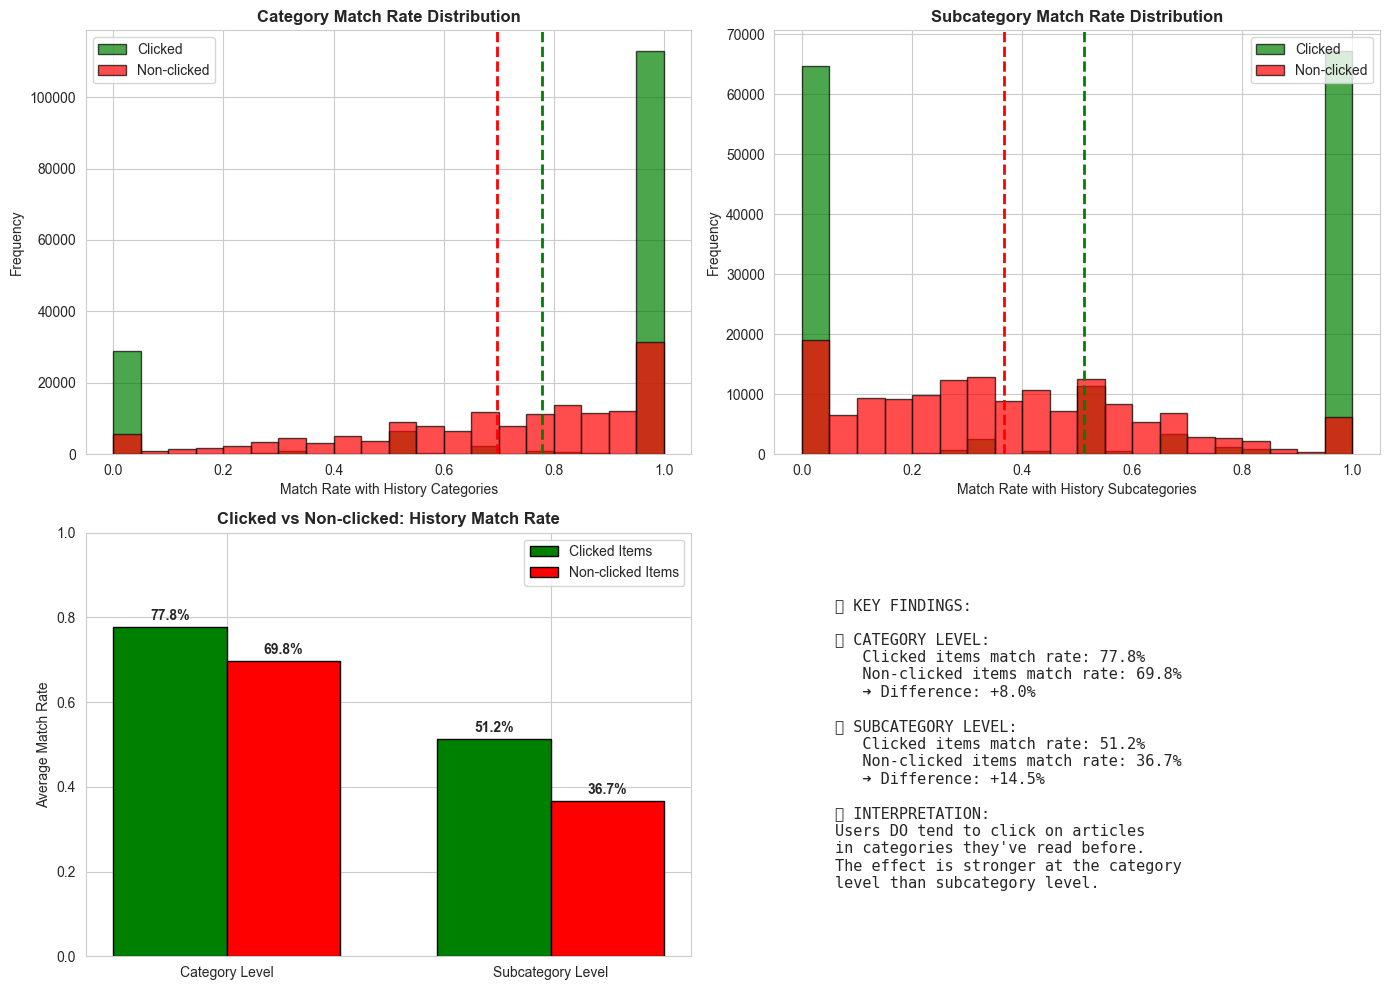

In [31]:
### 📊 Visualize Category Matching Results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Category level comparison
axes[0, 0].hist(category_df['clicked_match_rate'], bins=20, alpha=0.7, label='Clicked', color='green', edgecolor='black')
axes[0, 0].hist(category_df['non_clicked_match_rate'].dropna(), bins=20, alpha=0.7, label='Non-clicked', color='red', edgecolor='black')
axes[0, 0].set_xlabel('Match Rate with History Categories')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Category Match Rate Distribution', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].axvline(category_df['clicked_match_rate'].mean(), color='green', linestyle='--', linewidth=2)
axes[0, 0].axvline(category_df['non_clicked_match_rate'].mean(), color='red', linestyle='--', linewidth=2)

# Subcategory level comparison
axes[0, 1].hist(subcategory_df['clicked_match_rate'], bins=20, alpha=0.7, label='Clicked', color='green', edgecolor='black')
axes[0, 1].hist(subcategory_df['non_clicked_match_rate'].dropna(), bins=20, alpha=0.7, label='Non-clicked', color='red', edgecolor='black')
axes[0, 1].set_xlabel('Match Rate with History Subcategories')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Subcategory Match Rate Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].axvline(subcategory_df['clicked_match_rate'].mean(), color='green', linestyle='--', linewidth=2)
axes[0, 1].axvline(subcategory_df['non_clicked_match_rate'].mean(), color='red', linestyle='--', linewidth=2)

# Bar chart comparison
categories = ['Category Level', 'Subcategory Level']
clicked_means = [category_df['clicked_match_rate'].mean(), subcategory_df['clicked_match_rate'].mean()]
non_clicked_means = [category_df['non_clicked_match_rate'].mean(), subcategory_df['non_clicked_match_rate'].mean()]

x = np.arange(len(categories))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, clicked_means, width, label='Clicked Items', color='green', edgecolor='black')
bars2 = axes[1, 0].bar(x + width/2, non_clicked_means, width, label='Non-clicked Items', color='red', edgecolor='black')
axes[1, 0].set_ylabel('Average Match Rate')
axes[1, 0].set_title('Clicked vs Non-clicked: History Match Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(categories)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[1, 0].annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    axes[1, 0].annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontweight='bold')

# Text summary
summary_text = f"""
📊 KEY FINDINGS:

🎯 CATEGORY LEVEL:
   Clicked items match rate: {category_df['clicked_match_rate'].mean()*100:.1f}%
   Non-clicked items match rate: {category_df['non_clicked_match_rate'].mean()*100:.1f}%
   ➜ Difference: +{(category_df['clicked_match_rate'].mean() - category_df['non_clicked_match_rate'].mean())*100:.1f}%

🎯 SUBCATEGORY LEVEL:
   Clicked items match rate: {subcategory_df['clicked_match_rate'].mean()*100:.1f}%
   Non-clicked items match rate: {subcategory_df['non_clicked_match_rate'].mean()*100:.1f}%
   ➜ Difference: +{(subcategory_df['clicked_match_rate'].mean() - subcategory_df['non_clicked_match_rate'].mean())*100:.1f}%

💡 INTERPRETATION:
Users DO tend to click on articles
in categories they've read before.
The effect is stronger at the category
level than subcategory level.
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center', family='monospace')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

📊 4. USER INTEREST PROFILE ANALYSIS


/var/folders/w5/j0qkjxrd6dscd0k8bs4j073r0000gn/T/ipykernel_25362/1220049003.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ctr_by_diversity = users_with_history_copy.groupby('diversity_bin')['ctr'].mean()


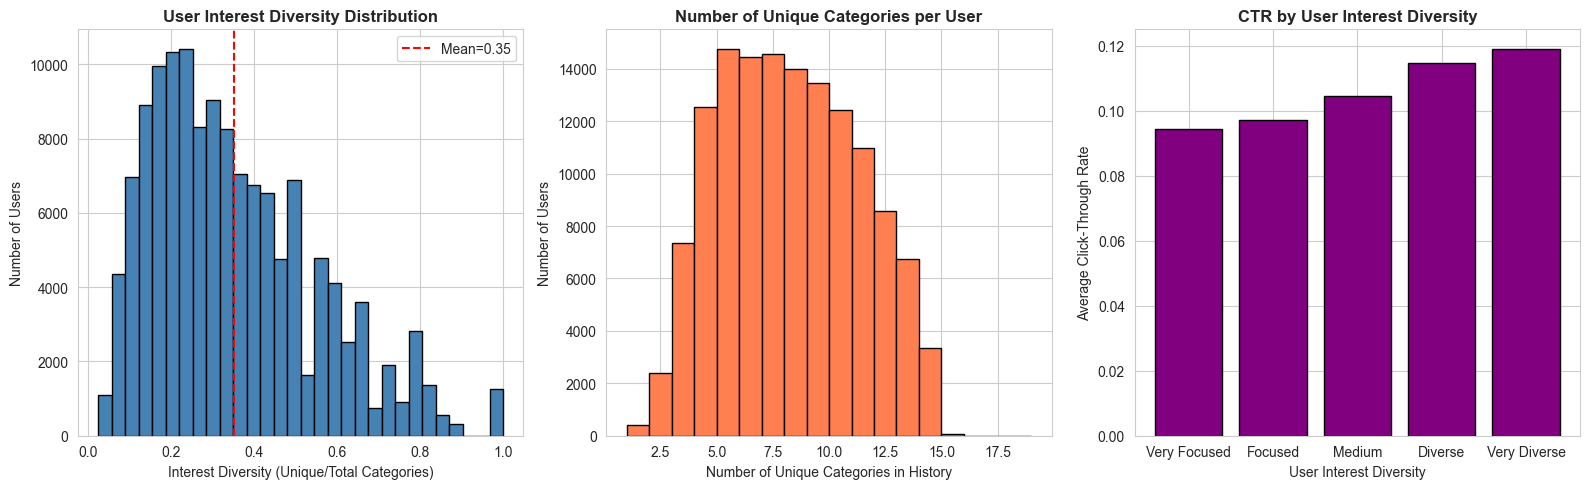


📈 User Diversity Statistics:
  Average diversity: 0.353
  Average unique categories per user: 7.8


In [32]:
### 📊 4. User Interest Profile Analysis
print("="*80)
print("📊 4. USER INTEREST PROFILE ANALYSIS")
print("="*80)

# Analyze how focused vs diverse users are
def calculate_interest_diversity(categories):
    """Calculate Gini coefficient for category distribution (higher = more focused)"""
    if not categories or len(categories) < 2:
        return None
    
    from collections import Counter
    counts = list(Counter(categories).values())
    n = len(counts)
    counts_sorted = sorted(counts)
    cumsum = np.cumsum(counts_sorted)
    return (2 * sum((i+1) * count for i, count in enumerate(counts_sorted)) / (n * sum(counts))) - (n + 1) / n

parsed_df['history_diversity'] = parsed_df['history_categories'].apply(
    lambda x: len(set(x)) / len(x) if x else None
)
parsed_df['num_unique_categories'] = parsed_df['history_categories'].apply(lambda x: len(set(x)))

# Filter users with meaningful history
users_with_history = parsed_df[parsed_df['history_count'] >= 5]

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# History diversity distribution
axes[0].hist(users_with_history['history_diversity'].dropna(), bins=30, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Interest Diversity (Unique/Total Categories)')
axes[0].set_ylabel('Number of Users')
axes[0].set_title('User Interest Diversity Distribution', fontsize=12, fontweight='bold')
axes[0].axvline(users_with_history['history_diversity'].mean(), color='red', linestyle='--', label=f'Mean={users_with_history["history_diversity"].mean():.2f}')
axes[0].legend()

# Number of unique categories per user
axes[1].hist(users_with_history['num_unique_categories'], bins=range(1, 20), color='coral', edgecolor='black')
axes[1].set_xlabel('Number of Unique Categories in History')
axes[1].set_ylabel('Number of Users')
axes[1].set_title('Number of Unique Categories per User', fontsize=12, fontweight='bold')

# Click rate by diversity
diversity_bins = pd.qcut(users_with_history['history_diversity'].dropna(), q=5, labels=['Very Focused', 'Focused', 'Medium', 'Diverse', 'Very Diverse'])
users_with_history_copy = users_with_history.copy()
users_with_history_copy['diversity_bin'] = diversity_bins
users_with_history_copy['ctr'] = users_with_history_copy['clicked_count'] / (users_with_history_copy['clicked_count'] + users_with_history_copy['non_clicked_count'])
ctr_by_diversity = users_with_history_copy.groupby('diversity_bin')['ctr'].mean()

axes[2].bar(ctr_by_diversity.index, ctr_by_diversity.values, color='purple', edgecolor='black')
axes[2].set_xlabel('User Interest Diversity')
axes[2].set_ylabel('Average Click-Through Rate')
axes[2].set_title('CTR by User Interest Diversity', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📈 User Diversity Statistics:")
print(f"  Average diversity: {users_with_history['history_diversity'].mean():.3f}")
print(f"  Average unique categories per user: {users_with_history['num_unique_categories'].mean():.1f}")

📊 5. CATEGORY-SPECIFIC CTR ANALYSIS


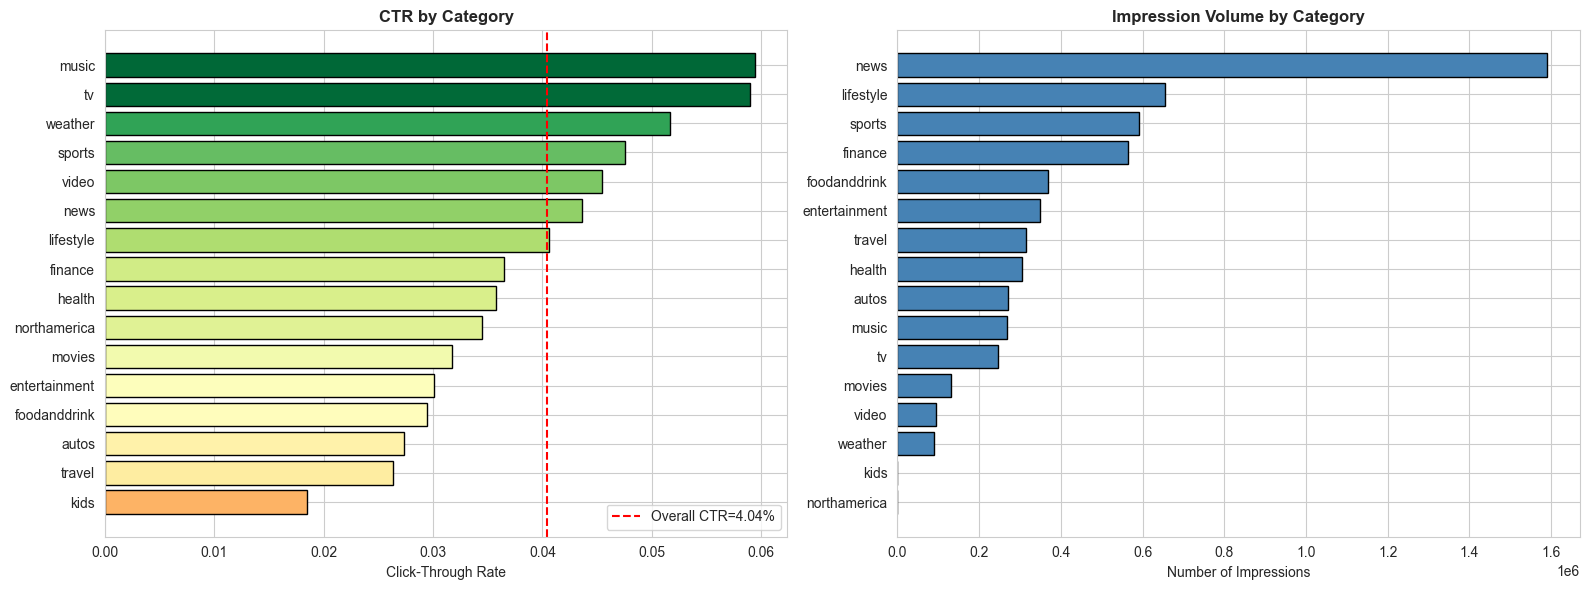


📈 Category CTR Summary:
  Overall CTR: 4.04%

🔝 Highest CTR Categories:
  video: 4.55% (4,262 clicks / 93,744 impressions)
  sports: 4.76% (28,181 clicks / 592,226 impressions)
  weather: 5.17% (4,582 clicks / 88,646 impressions)
  tv: 5.90% (14,544 clicks / 246,462 impressions)
  music: 5.94% (15,988 clicks / 269,008 impressions)

🔻 Lowest CTR Categories:
  kids: 1.85% (3 clicks / 162 impressions)
  travel: 2.64% (8,304 clicks / 315,101 impressions)
  autos: 2.74% (7,428 clicks / 271,426 impressions)
  foodanddrink: 2.95% (10,883 clicks / 369,382 impressions)
  entertainment: 3.01% (10,530 clicks / 349,930 impressions)


In [33]:
### 📊 5. Category Click-Through Rate Analysis
print("="*80)
print("📊 5. CATEGORY-SPECIFIC CTR ANALYSIS")
print("="*80)

# Analyze CTR by category
category_clicks = []
for _, row in parsed_df.iterrows():
    for cat in row['clicked_categories']:
        category_clicks.append({'category': cat, 'clicked': 1})
    for cat in row['non_clicked_categories']:
        category_clicks.append({'category': cat, 'clicked': 0})

category_ctr_df = pd.DataFrame(category_clicks)
category_ctr = category_ctr_df.groupby('category').agg(
    total_impressions=('clicked', 'count'),
    total_clicks=('clicked', 'sum')
).reset_index()
category_ctr['ctr'] = category_ctr['total_clicks'] / category_ctr['total_impressions']
category_ctr = category_ctr.sort_values('ctr', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CTR by category
colors = plt.cm.RdYlGn(category_ctr['ctr'] / category_ctr['ctr'].max())
axes[0].barh(category_ctr['category'], category_ctr['ctr'], color=colors, edgecolor='black')
axes[0].set_xlabel('Click-Through Rate')
axes[0].set_title('CTR by Category', fontsize=12, fontweight='bold')
axes[0].axvline(category_ctr_df['clicked'].mean(), color='red', linestyle='--', label=f'Overall CTR={category_ctr_df["clicked"].mean():.2%}')
axes[0].legend()

# Impression volume by category
category_ctr_sorted = category_ctr.sort_values('total_impressions', ascending=True)
axes[1].barh(category_ctr_sorted['category'], category_ctr_sorted['total_impressions'], color='steelblue', edgecolor='black')
axes[1].set_xlabel('Number of Impressions')
axes[1].set_title('Impression Volume by Category', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📈 Category CTR Summary:")
print(f"  Overall CTR: {category_ctr_df['clicked'].mean():.2%}")
print(f"\n🔝 Highest CTR Categories:")
for _, row in category_ctr.tail(5).iterrows():
    print(f"  {row['category']}: {row['ctr']:.2%} ({row['total_clicks']:,} clicks / {row['total_impressions']:,} impressions)")
print(f"\n🔻 Lowest CTR Categories:")
for _, row in category_ctr.head(5).iterrows():
    print(f"  {row['category']}: {row['ctr']:.2%} ({row['total_clicks']:,} clicks / {row['total_impressions']:,} impressions)")

📊 6. TEMPORAL ANALYSIS


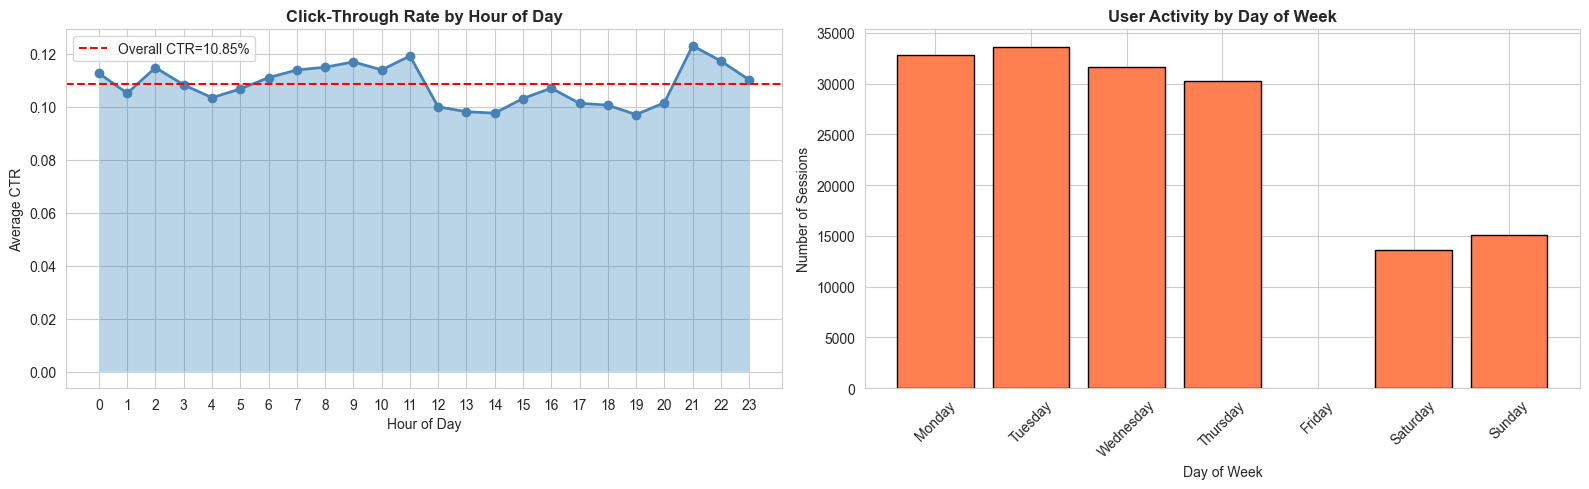


📈 Temporal Patterns:
  Peak hour: 21:00 (CTR: 12.31%)
  Lowest hour: 19:00 (CTR: 9.71%)
  Most active day: Tuesday (33,654.0 sessions)


In [34]:
### 📊 6. Temporal Analysis
print("="*80)
print("📊 6. TEMPORAL ANALYSIS")
print("="*80)

# Parse timestamps
behaviors_full['datetime'] = pd.to_datetime(behaviors_full['time'], format='%m/%d/%Y %I:%M:%S %p')
behaviors_full['hour'] = behaviors_full['datetime'].dt.hour
behaviors_full['dayofweek'] = behaviors_full['datetime'].dt.dayofweek
behaviors_full['day_name'] = behaviors_full['datetime'].dt.day_name()

# Calculate clicks and impressions per time slot
def count_clicks(imp_str):
    return sum(1 for imp in str(imp_str).split() if imp.split('-')[1] == '1')

def count_impressions(imp_str):
    return len(str(imp_str).split())

behaviors_full['clicks'] = behaviors_full['impressions'].apply(count_clicks)
behaviors_full['total_impressions'] = behaviors_full['impressions'].apply(count_impressions)
behaviors_full['ctr'] = behaviors_full['clicks'] / behaviors_full['total_impressions']

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# CTR by hour
hourly_ctr = behaviors_full.groupby('hour')['ctr'].mean()
axes[0].plot(hourly_ctr.index, hourly_ctr.values, marker='o', linewidth=2, color='steelblue')
axes[0].fill_between(hourly_ctr.index, hourly_ctr.values, alpha=0.3)
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average CTR')
axes[0].set_title('Click-Through Rate by Hour of Day', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(0, 24))
axes[0].axhline(behaviors_full['ctr'].mean(), color='red', linestyle='--', label=f'Overall CTR={behaviors_full["ctr"].mean():.2%}')
axes[0].legend()

# Activity by day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = behaviors_full.groupby('day_name').size().reindex(day_order)
axes[1].bar(daily_activity.index, daily_activity.values, color='coral', edgecolor='black')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Sessions')
axes[1].set_title('User Activity by Day of Week', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n📈 Temporal Patterns:")
print(f"  Peak hour: {hourly_ctr.idxmax()}:00 (CTR: {hourly_ctr.max():.2%})")
print(f"  Lowest hour: {hourly_ctr.idxmin()}:00 (CTR: {hourly_ctr.min():.2%})")
print(f"  Most active day: {daily_activity.idxmax()} ({daily_activity.max():,} sessions)")

In [35]:
### 📊 7. COMPREHENSIVE SUMMARY
print("="*80)
print("📊 COMPREHENSIVE DATASET SUMMARY")
print("="*80)

summary = f"""
📰 NEWS ARTICLES:
   - Total articles: {len(news_full):,}
   - Categories: {news_full['category'].nunique()}
   - Subcategories: {news_full['subcategory'].nunique()}
   - Average title length: {news_full['title'].str.split().str.len().mean():.1f} words

👤 USER BEHAVIORS:
   - Total impressions: {len(behaviors_full):,}
   - Unique users: {behaviors_full['user_id'].nunique():,}
   - Average history length: {parsed_df['history_count'].mean():.1f} articles
   - Average impressions per session: {behaviors_full['total_impressions'].mean():.1f}
   - Overall CTR: {behaviors_full['ctr'].mean():.2%}

🎯 KEY INSIGHTS - CATEGORY MATCHING:
   1. Users DO prefer articles matching their history:
      - Category match rate: Clicked {category_df['clicked_match_rate'].mean()*100:.1f}% vs Non-clicked {category_df['non_clicked_match_rate'].mean()*100:.1f}%
      - Subcategory match rate: Clicked {subcategory_df['clicked_match_rate'].mean()*100:.1f}% vs Non-clicked {subcategory_df['non_clicked_match_rate'].mean()*100:.1f}%
   
   2. The category matching effect is stronger than subcategory
      (broader topic preference > specific niche preference)

📊 IMPLICATIONS FOR RECOMMENDATION:
   - Category-based collaborative filtering could be effective
   - User history is a strong signal for predicting clicks
   - Consider both category and subcategory features in models
   - Personalization based on reading history is justified

🏆 TOP PERFORMING CATEGORIES (by CTR):
"""

for _, row in category_ctr.tail(3).iterrows():
    summary += f"   - {row['category']}: {row['ctr']:.2%}\n"

print(summary)
print("="*80)

📊 COMPREHENSIVE DATASET SUMMARY

📰 NEWS ARTICLES:
   - Total articles: 65,238
   - Categories: 18
   - Subcategories: 270
   - Average title length: 10.7 words

👤 USER BEHAVIORS:
   - Total impressions: 156,965
   - Unique users: 50,000
   - Average history length: 32.5 articles
   - Average impressions per session: 37.2
   - Overall CTR: 10.85%

🎯 KEY INSIGHTS - CATEGORY MATCHING:
   1. Users DO prefer articles matching their history:
      - Category match rate: Clicked 77.8% vs Non-clicked 69.8%
      - Subcategory match rate: Clicked 51.2% vs Non-clicked 36.7%
   
   2. The category matching effect is stronger than subcategory
      (broader topic preference > specific niche preference)

📊 IMPLICATIONS FOR RECOMMENDATION:
   - Category-based collaborative filtering could be effective
   - User history is a strong signal for predicting clicks
   - Consider both category and subcategory features in models
   - Personalization based on reading history is justified

🏆 TOP PERFORMING CA